In [187]:
from os import getcwd

import pdb
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import twitter_samples
from nltk.tokenize import TweetTokenizer
nltk.data.path.append('.')

import pandas as pd
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt

import random
import re
import string
import time
from collections import Counter
from collections import defaultdict
import pickle
import math

import gensim
from gensim.models import KeyedVectors

%matplotlib inline
%config InlineBackend.figure_format='svg'

In [2]:
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/diegobatalhacunhadasilva/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegobatalhacunhadasilva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

#split the data
train_pos=all_positive_tweets[:4000]
test_pos=all_positive_tweets[4000:] #from 4000-5000
train_neg=all_negative_tweets[:4000]
test_neg=all_negative_tweets[4000:] #from 4000-5000

train_x=train_pos+train_neg
test_x=test_pos+test_neg

train_y=np.append(np.ones((len(train_pos),1)),np.zeros((len(train_neg),1)),axis=0)
test_y=np.append(np.ones((len(test_pos),1)),np.zeros((len(test_neg),1)),axis=0)

In [4]:
# Pre Processing

In [30]:
def process_tweet(tweet):
    stemmer=PorterStemmer()
    stopwords_english=stopwords.words('english')
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    tokenizer=TweetTokenizer(preserve_case=False,strip_handles=True,
                             reduce_len=True)
    
    tweet_tokens=tokenizer.tokenize(tweet)
    
    tweets_clean=[]
    # remove stopwords
    # remove punctuation
    for word in tweet_tokens:
        if word not in stopwords_english and\
            word not in string.punctuation:
            stem_word=stemmer.stem(word)
            tweets_clean.append(stem_word)
    return tweets_clean

In [227]:
def build_freqs(tweets,ys):
    yslist = np.squeeze(ys).tolist()
    freqs={}
    for y,tweet in zip(yslist,tweets):
        for word in process_tweet(tweet):
            pair=(word,y)
            
            if pair in freqs:
                freqs[pair]+=1
            else:
                freqs[pair]=1
                
    return freqs

In [228]:
freqs = build_freqs(train_x, train_y)
freqs

{('followfriday', 1.0): 23,
 ('top', 1.0): 30,
 ('engag', 1.0): 7,
 ('member', 1.0): 14,
 ('commun', 1.0): 27,
 ('week', 1.0): 72,
 (':)', 1.0): 2847,
 ('hey', 1.0): 60,
 ('jame', 1.0): 7,
 ('odd', 1.0): 2,
 (':/', 1.0): 5,
 ('pleas', 1.0): 80,
 ('call', 1.0): 27,
 ('contact', 1.0): 4,
 ('centr', 1.0): 1,
 ('02392441234', 1.0): 1,
 ('abl', 1.0): 6,
 ('assist', 1.0): 1,
 ('mani', 1.0): 28,
 ('thank', 1.0): 504,
 ('listen', 1.0): 14,
 ('last', 1.0): 39,
 ('night', 1.0): 55,
 ('bleed', 1.0): 2,
 ('amaz', 1.0): 41,
 ('track', 1.0): 5,
 ('scotland', 1.0): 2,
 ('congrat', 1.0): 15,
 ('yeaaah', 1.0): 1,
 ('yipppi', 1.0): 1,
 ('accnt', 1.0): 2,
 ('verifi', 1.0): 2,
 ('rqst', 1.0): 1,
 ('succeed', 1.0): 1,
 ('got', 1.0): 57,
 ('blue', 1.0): 8,
 ('tick', 1.0): 1,
 ('mark', 1.0): 1,
 ('fb', 1.0): 4,
 ('profil', 1.0): 2,
 ('15', 1.0): 4,
 ('day', 1.0): 187,
 ('one', 1.0): 90,
 ('irresist', 1.0): 2,
 ('flipkartfashionfriday', 1.0): 16,
 ('like', 1.0): 187,
 ('keep', 1.0): 55,
 ('love', 1.0): 336,
 

In [216]:
# Logistic Regression

In [217]:
def sigmoid(z):   
    return 1/(1+np.exp(-z))

In [218]:
# Gradient Descent

In [219]:
def gradient(x,y,theta,alpha,num_iters):
    m=x.shape[0]
    
    for i in range(num_iters):
        z=np.dot(x,theta)
        h=sigmoid(z)
        J = -1./m * (np.dot(y.transpose(), np.log(h)) + np.dot((1-y).transpose(),np.log(1-h)))                                                    
        theta=theta-(alpha/m)*np.dot(x.transpose(),(h-y))
        
    J=float(J)
    
    return J,theta

In [220]:
# Check the function
# Construct a synthetic test case using numpy PRNG functions
np.random.seed(1)
# X input is 10 x 3 with ones for the bias terms
tmp_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)
# Y Labels are 10 x 1
tmp_Y = (np.random.rand(10, 1) > 0.35).astype(float)

# Apply gradient descent
tmp_J, tmp_theta = gradient(tmp_X, tmp_Y, np.zeros((3, 1)), 1e-8, 700)
print(f"The cost after training is {tmp_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(tmp_theta)]}")

The cost after training is 0.67094970.
The resulting vector of weights is [4.1e-07, 0.00035658, 7.309e-05]


In [221]:
# Extracting the Features

In [222]:
def extract_features(tweet,freqs):
    word_1=process_tweet(tweet)
    x=np.zeros((1,3))
    
    x[0,0]=1
    
    for word in word_1:
        x[0,1]+=freqs.get((word,1.),0)
        x[0,2]+=freqs.get((word,0.),0)
    
    assert(x.shape==(1,3))
    
    return x

In [223]:
# Check your function
tmp1 = extract_features(train_x[0], freqs)
print(tmp1)

[[1.00e+00 3.02e+03 6.10e+01]]


In [224]:
# Check for when the words are not in the freqs dictionary
tmp2 = extract_features('blorb bleeeeb bloooob', freqs)
print(tmp2)

[[1. 0. 0.]]


In [225]:
#Training Model

In [277]:
X=np.zeros((len(train_x),3))
for i in range(len(train_x)):
    X[i,:]=extract_features(train_x[i],freqs)
    
Y=train_y

J,theta=gradient(X,Y,np.zeros((3,1)),1e-9,1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

NameError: name 'train_x' is not defined

In [ ]:
#Test Logistic Regression

In [ ]:
def predict_tweet(tweet,freqs,theta):
    x=extract_features(tweet,freqs)
    y_pred=sigmoid(np.dot(x,theta))
    
    return y_pred

In [ ]:
def sentiment(x):
    return str('Good') if x>0.5 else str('Bad')

In [69]:
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.',\
              'great', 'great great', 'great great great', 'great great great great']:
    print( '{} -> {} -> {}' .format(tweet,predict_tweet(tweet,freqs,theta)[0][0] ,sentiment(predict_tweet(tweet, freqs, theta)[0][0])))

I am happy -> 0.5185801561975211 -> Good
I am bad -> 0.4943391042897527 -> Bad
this movie should have been great. -> 0.515331061366408 -> Good
great -> 0.5154638369272457 -> Good
great great -> 0.5308981010928904 -> Good
great great great -> 0.5462734815407703 -> Good
great great great great -> 0.5615610965558285 -> Good


In [70]:
my_tweet = 'I am learning :)'
predict_tweet(my_tweet, freqs, theta)

array([[0.81636482]])

In [72]:
def test_lr(test_x,test_y,freqs,theta):
    y_hat=[]
    
    for tweet in test_x:
        y_pred=predict_tweet(tweet,freqs,theta)
        y_hat.append(1) if y_pred>0.5 else y_hat.append(0)
            
    accuracy=(y_hat==np.squeeze(test_y)).sum()/len(test_x)
    
    return accuracy

In [73]:
tmp_accuracy = test_lr(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9950


In [74]:
#Error Analysis

In [75]:
# Some error analysis done for you
print('Label Predicted Tweet')
for x,y in zip(test_x,test_y):
    y_hat = predict_tweet(x, freqs, theta)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))

Label Predicted Tweet
THE TWEET IS: @jaredNOTsubway @iluvmariah @Bravotv Then that truly is a LATERAL move! Now, we all know the Queen Bee is UPWARD BOUND : ) #MovingOnUp
THE PROCESSED TWEET IS: ['truli', 'later', 'move', 'know', 'queen', 'bee', 'upward', 'bound', 'movingonup']
1	0.49996897	b'truli later move know queen bee upward bound movingonup'
THE TWEET IS: @MarkBreech Not sure it would be good thing 4 my bottom daring 2 say 2 Miss B but Im gonna be so stubborn on mouth soaping ! #NotHavingit :p
THE PROCESSED TWEET IS: ['sure', 'would', 'good', 'thing', '4', 'bottom', 'dare', '2', 'say', '2', 'miss', 'b', 'im', 'gonna', 'stubborn', 'mouth', 'soap', 'nothavingit', ':p']
1	0.48650628	b'sure would good thing 4 bottom dare 2 say 2 miss b im gonna stubborn mouth soap nothavingit :p'
THE TWEET IS: I'm playing Brain Dots : ) #BrainDots
http://t.co/UGQzOx0huu
THE PROCESSED TWEET IS: ["i'm", 'play', 'brain', 'dot', 'braindot']
1	0.48370676	b"i'm play brain dot braindot"
THE TWEET IS: I'm p

In [76]:
# With a New Tweet

In [78]:
# Feel free to change the tweet below
my_tweet = 'This is an awesome movie. Incredible!'
print(process_tweet(my_tweet))
y_hat = predict_tweet(my_tweet, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')
else: 
    print('Negative sentiment')

['awesom', 'movi', 'incred']
[[0.50441204]]
Positive sentiment


In [88]:
# ENDS Logistic Regression

In [ ]:
# Starting Naive Bayes

In [210]:
# Train Model Using Naive Bayes

In [229]:
all_positive_tweets=twitter_samples.strings('positive_tweets.json')
all_negative_tweets=twitter_samples.strings('negative_tweets.json')

# Split the data
train_pos=all_positive_tweets[:4000]
test_pos=all_positive_tweets[4000:]
train_neg=all_negative_tweets[:4000]
test_neg=all_negative_tweets[4000:]

train_x=train_pos+train_neg
test_x=test_pos+test_neg

train_y=np.append(np.ones(len(train_pos)),np.zeros(len(train_neg)))
test_y=np.append(np.ones(len(test_pos)),np.zeros(len(test_neg)))

In [230]:
def count_tweets(result,tweets,ys):
    for y,tweet in zip(ys,tweets):
        for word in process_tweet(tweet):
            pair=(word,y)
            
            if pair in result:
                result[pair]+=1
            else:
                result[pair]=1
                
    return result

In [231]:
def lookup(freqs,word,label):
    n=0
    pair=(word,label)
    
    if pair in freqs:
        n=freqs[pair]
    return n

In [232]:
def train_naive_bayes(freqs,train_x,train_y):
    loglikelihood={}
    logprior=0
    
    # Calculate V,the number of unique words in the vocab
    vocab=set([pair[0] for pair in freqs.keys()])
    V=len(vocab)
    
    # Calculate N_pos,N_neg,V_pos,V_neg
    N_pos=N_neg=0
#     V_pos=V_neg=0
    
    for pair in freqs.keys():
        if pair[1]>0:
#             V_pos+=1
            N_pos+=freqs[pair]
        else:
#             V_neg+=1
            N_neg+=freqs[pair]
    
#     D=len(train_y)

    # Calculate D_pos,the number of positive documents
    D_pos=(len(list(filter(lambda x:x>0,train_y))))
         
    # Calculate D_neg,the number of negative documents
    D_neg=(len(list(filter(lambda x:x<=0,train_y))))

    # Calculate logprior
    logprior=np.log(D_pos)-np.log(D_neg)
    
    for word in vocab:
        # Calculate the frequency of positive/negative word
        freq_pos=lookup(freqs,word,1)
        freq_neg=lookup(freqs,word,0)
        
        # Calculate the probability that each word is positice/negative
        p_w_pos=(freq_pos+1)/(N_pos+V)
        p_w_neg=(freq_neg+1)/(N_neg+V)
        
        # Calculate the log likelihood of the word
        loglikelihood[word]=np.log(p_w_pos/p_w_neg)
        
    return logprior,loglikelihood

In [233]:
logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)
print(logprior)
print(len(loglikelihood))

0.0
9085


In [158]:
# Test Naive Bayes

In [159]:
def naive_bayes_predict(tweet,logprior,loglikelihood):
    word_1=process_tweet(tweet)
    
    p=0
    
    p+=logprior
    
    for word in word_1:
        if word in loglikelihood:
            p+=loglikelihood[word]
        
    return p

In [160]:
def test_naive_bayes(test_x,test_y,logprior,loglikelihood):
    accuracy=0
    y_hats=[]
    
    for tweet in test_x:
        if naive_bayes_predict(tweet,logprior,loglikelihood)>0:
            y_hat_i=1
        else:
            y_hat_i=0
        y_hats.append(y_hat_i)
    
    error=np.mean(np.absolute(y_hats-test_y))
    
    accuracy=1-error
    
    return accuracy

In [161]:
# Filter words by Ratio of positive to negative counts

In [162]:
def get_ratio(freqs,word):
    pos_neg_ratio = {'positive': 0, 'negative': 0, 'ratio': 0.0}
   
    pos_neg_ratio['positive'] = lookup(freqs,word,1)

    pos_neg_ratio['negative'] = lookup(freqs,word,0)

    # calculate the ratio of positive to negative counts for the word
    pos_neg_ratio['ratio'] = (pos_neg_ratio['positive'] + 1)/(pos_neg_ratio['negative'] + 1)

    return pos_neg_ratio

In [163]:
get_ratio(freqs, 'happi')

{'negative': 18, 'positive': 161, 'ratio': 8.526315789473685}

In [164]:
def get_words_by_threshold(freqs,label,threshold):
    word_list = {}

    for key in freqs.keys():
        word, _ = key

        pos_neg_ratio = get_ratio(freqs, word)

        if label == 1 and pos_neg_ratio['ratio'] >= threshold :

            word_list[word] = pos_neg_ratio

        elif label == 0 and pos_neg_ratio['ratio'] <= threshold:
            
            word_list[word] = pos_neg_ratio

    return word_list

In [165]:
get_words_by_threshold(freqs, label=1, threshold=10)

{':)': {'negative': 2, 'positive': 2847, 'ratio': 949.3333333333334},
 ':-)': {'negative': 0, 'positive': 543, 'ratio': 544.0},
 ':D': {'negative': 0, 'positive': 498, 'ratio': 499.0},
 ':p': {'negative': 0, 'positive': 103, 'ratio': 104.0},
 ';)': {'negative': 0, 'positive': 22, 'ratio': 23.0},
 'arriv': {'negative': 4, 'positive': 57, 'ratio': 11.6},
 'bam': {'negative': 0, 'positive': 44, 'ratio': 45.0},
 'blog': {'negative': 0, 'positive': 27, 'ratio': 28.0},
 'commun': {'negative': 1, 'positive': 27, 'ratio': 14.0},
 'fav': {'negative': 0, 'positive': 11, 'ratio': 12.0},
 'fback': {'negative': 0, 'positive': 26, 'ratio': 27.0},
 'flipkartfashionfriday': {'negative': 0, 'positive': 16, 'ratio': 17.0},
 'followfriday': {'negative': 0, 'positive': 23, 'ratio': 24.0},
 'glad': {'negative': 2, 'positive': 41, 'ratio': 14.0},
 "here'": {'negative': 0, 'positive': 20, 'ratio': 21.0},
 'influenc': {'negative': 0, 'positive': 16, 'ratio': 17.0},
 'pleasur': {'negative': 0, 'positive': 10, 

In [166]:
# error analysis

In [167]:
# error demo
print('Truth Predicted Tweet')
for x, y in zip(test_x, test_y):
    y_hat = naive_bayes_predict(x, logprior, loglikelihood)
    if y != (np.sign(y_hat) > 0):
        print('%d\t%0.2f\t%s' % (y, np.sign(y_hat) > 0, ' '.join(
            process_tweet(x)).encode('ascii', 'ignore')))

Truth Predicted Tweet
1	0.00	b''
1	0.00	b'truli later move know queen bee upward bound movingonup'
1	0.00	b'new report talk burn calori cold work harder warm feel better weather :p'
1	0.00	b'harri niall 94 harri born ik stupid wanna chang :D'
1	0.00	b''
1	0.00	b''
1	0.00	b'park get sunlight'
1	0.00	b'uff itna miss karhi thi ap :p'
0	1.00	b'hello info possibl interest jonatha close join beti :( great'
0	1.00	b'u prob fun david'
0	1.00	b'pat jay'
0	1.00	b'whatev stil l young >:-('


In [168]:
my_tweet = 'Oh shit, this is fantastic'

p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print(p)

0.8389995664033365


In [6]:
# Starting PCA and Word Embeddings

In [36]:
data=pd.read_csv('capitals.txt',delimiter=' ')
data.columns=['city1','country1','city2','country2']

data.head()

,city1,country1,city2,country2
0,Athens,Greece,Bangkok,Thailand
1,Athens,Greece,Beijing,China
2,Athens,Greece,Berlin,Germany
3,Athens,Greece,Bern,Switzerland
4,Athens,Greece,Cairo,Egypt


In [37]:
# embeddings = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)
# f = open('capitals.txt', 'r').read()
# set_words = set(nltk.word_tokenize(f))
# select_words = words = ['king', 'queen', 'oil', 'gas', 'happy', 'sad', 'city', 'town', 'village', 'country', 'continent', 'petroleum', 'joyful']
# for w in select_words:
#     set_words.add(w)

In [38]:
# def get_word_embeddings(embeddings):

#     word_embeddings = {}
#     for word in embeddings.vocab:
#         if word in set_words:
#             word_embeddings[word] = embeddings[word]
#     return word_embeddings

In [39]:
# # Testing your function
# word_embeddings = get_word_embeddings(embeddings)
# print(len(word_embeddings))
# pickle.dump( word_embeddings, open( "word_embeddings_subset.p", "wb" ) )

In [40]:
word_embeddings=pickle.load(open('./word_embeddings_subset.p','rb'))
print(len(word_embeddings))

243


In [41]:
print("dimension: {}".format(word_embeddings['Spain'].shape[0]))

dimension: 300


In [21]:
#Predict Similarity between words

In [22]:
def cosine_similarity(A,B):
    dot=np.dot(A,B)
    
    norma=np.sqrt((np.dot(A,A)))
    normb=np.sqrt((np.dot(B,B)))
    cos=dot/(norma*normb)
    
    return cos

In [23]:
# Try

king = word_embeddings['king']
queen = word_embeddings['queen']

cosine_similarity(king, queen)

0.6510956

In [24]:
def euclidean(A,B):
    return np.linalg.norm(A-B)

In [25]:
# Test
euclidean(king, queen)

2.4796925

In [26]:
def get_country(city1,country1,city2,embeddings):
    group=set((city1,country1,city2))
    
    # get the embedding of city1
    city1_emb=word_embeddings[city1]
    
    # get the embedding of country1
    country1_emb=word_embeddings[country1]
    
    # get the embedding of city2
    city2_emb=word_embeddings[city2]
    
    # formula:King - Man + Woman = Queen
    vec=country1_emb-city1_emb+city2_emb
    
    similarity=-1
    country=''
    
    for word in embeddings.keys():
        if word not in group:
            word_emb=word_embeddings[word]
            cur_similarity=cosine_similarity(vec,word_emb)
            
            if cur_similarity>similarity:
                similarity=cur_similarity
                country=(word,similarity)
    return country

In [27]:
# Test
get_country('Athens', 'Greece', 'Cairo', word_embeddings)

('Egypt', 0.7626821)

In [28]:
def get_accuracy(word_embedding,data):
    num_correct=0
    
    for i,row in data.iterrows():
        city1=row['city1']
        country1=row['country1']
        city2=row['city2']
        country2=row['country2']
        
        # get_country function to find the predicted country2
        predicted_country2,_=get_country(city1,country1,city2,word_embedding)
        
        if predicted_country2==country2:
            num_correct+=1
    
    accuracy=num_correct/len(data)
    
    return accuracy


In [29]:
accuracy = get_accuracy(word_embeddings, data)
print(f"Accuracy is {accuracy:.2f}")

Accuracy is 0.92


In [30]:
#Plotting the vector using VCA

In [31]:
def compute_pca(X,n_components=2):
    """
    Input:
        X: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output:
        X_reduced: data transformed in 2 dims/columns + regenerated original data
    """
    X_demeaned=X-np.mean(X,axis=0)
    print("X_demeaned.shape: ",X_demeaned.shape)
    
    # calculate the covariance matrix
    covariance_matrix = np.cov(X_demeaned, rowvar=False)

    # calculate eigenvectors & eigenvalues of the covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix, UPLO='L')
    
    # sort eigenvalue in increasing order (get the indices from the sort)
    idx_sorted = np.argsort(eigen_vals)
    
    # reverse the order so that it's from highest to lowest.
    idx_sorted_decreasing = idx_sorted[::-1]
    
    # sort the eigen values by idx_sorted_decreasing
    eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]

    # sort eigenvectors using the idx_sorted_decreasing indices
    eigen_vecs_sorted = eigen_vecs[:,idx_sorted_decreasing]

    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    eigen_vecs_subset = eigen_vecs_sorted[:,0:n_components]

    # transform the data by multiplying the transpose of the eigenvectors 
    # with the transpose of the de-meaned data
    # Then take the transpose of that product.
    X_reduced = np.dot(eigen_vecs_subset.transpose(),X_demeaned.transpose()).transpose()

    return X_reduced

In [32]:
# Testi

np.random.seed(1)
X = np.random.rand(3, 10)

X_reduced = compute_pca(X, n_components=2)
print("Your original matrix was " + str(X.shape) + " and it became:")
print(X_reduced)

X_demeaned.shape:  (3, 10)
Your original matrix was (3, 10) and it became:
[[ 0.43437323  0.49820384]
 [ 0.42077249 -0.50351448]
 [-0.85514571  0.00531064]]


In [33]:
def get_vectors(embeddings, words):
    """
    Input:
        embeddings: a word 
        fr_embeddings:
        words: a list of words
    Output: 
        X: a matrix where the rows are the embeddings corresponding to the rows on the list
        
    """
    m = len(words)
    X = np.zeros((1, 300))
    for word in words:
        english = word
        eng_emb = embeddings[english]
        X = np.row_stack((X, eng_emb))
    X = X[1:,:]
    return X

In [34]:
words = ['oil', 'gas', 'happy', 'sad', 'city', 'town',
         'village', 'country', 'continent', 'petroleum', 'joyful']

# given a list of words and the embeddings, it returns a matrix with all the embeddings
X = get_vectors(word_embeddings, words)

print('You have 11 words each of 300 dimensions thus X.shape is:', X.shape)

You have 11 words each of 300 dimensions thus X.shape is: (11, 300)


X_demeaned.shape:  (11, 300)


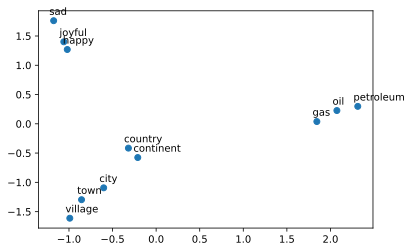

In [35]:
# We have done the plotting for you. Just run this cell.
result = compute_pca(X, 2)
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0] - 0.05, result[i, 1] + 0.1))

plt.show()

In [3]:
en_embeddings_subset=pickle.load(open("en_embeddings.p","rb"))
fr_embeddings_subset=pickle.load(open("fr_embeddings.p","rb"))

In [6]:
def get_dict(file_name):
    my_file=pd.read_csv(file_name,delimiter=' ')
    
    etof={}
    
    for i in range(len(my_file)):
        en=my_file.iloc[i][0]
        fr=my_file.iloc[i][1]
        etof[en] = fr
        
    return etof

In [7]:
en_fr_train = get_dict('en-fr.train.txt')
print('The length of the English to French training dictionary is', len(en_fr_train))
en_fr_test = get_dict('en-fr.test.txt')
print('The length of the English to French test dictionary is', len(en_fr_train))

The length of the English to French training dictionary is 5000
The length of the English to French test dictionary is 5000


In [8]:
def get_matrices(en_fr,french_vecs,english_vecs):
    """
    Input:
        en_fr: English to French dictionary
        french_vecs: French words to their corresponding word embeddings.
        english_vecs: English words to their corresponding word embeddings.
    Output: 
        X: a matrix where the columns are the English embeddings.
        Y: a matrix where the columns correspong to the French embeddings.
        R: the projection matrix that minimizes the F norm ||X R -Y||^2.
    """
    
    # X_l and Y_l are lists of the english and french word embeddings
    X_l=list()
    Y_l=list()
    
    # get the english words (the keys in the dictionary) and store in a set()
    english_set=english_vecs.keys()
    
    # get the french words (the keys in the dictionary) and store in a set()
    french_set=french_vecs.keys()
    
    # store the french words that are part of the english-french dictionary
    french_words=set(en_fr.values())
    
    for en_word,fr_word in en_fr.items():
        if fr_word in french_set and en_word in english_set:
            en_vec=english_vecs[en_word]
            
            fr_vec=french_vecs[fr_word]
            
            X_l.append(en_vec)
            
            Y_l.append(fr_vec)
    
    X=np.vstack(X_l)
    
    Y=np.vstack(Y_l)
    
    return X,Y

In [14]:
X_train, Y_train = get_matrices(
    en_fr_train, fr_embeddings_subset, en_embeddings_subset)

In [9]:
def compute_loss(X,Y,R):
    '''
    Inputs: 
        X: a matrix of dimension (m,n) where the columns are the English embeddings.
        Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
        R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
        L: a matrix of dimension (m,n) - the value of the loss function for given X, Y and R.
    '''
    
    m=X.shape[0]
    
    diff=np.dot(X,R)-Y
    
    diff_squared=diff**2
    
    sum_diff_squared=np.sum(diff_squared)
    
    loss=sum_diff_squared/m
    
    return loss

In [10]:
def compute_gradient(X,Y,R):
    '''
    Inputs: 
        X: a matrix of dimension (m,n) where the columns are the English embeddings.
        Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
        R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
        g: a matrix of dimension (n,n) - gradient of the loss function L for given X, Y and R.
    '''
    m=X.shape[0]
    
    gradient=np.dot(X.T,np.dot(X,R)-Y)*(2/m)
    
    return gradient

In [11]:
def align_embeddings(X,Y,train_steps=100,learning_rate=0.0003):
    np.random.seed(129)
    
    R=np.random.rand(X.shape[1],X.shape[1])
    
    for i in range(train_steps):
        if i%25 ==0:
            print("loss at iteration {} is {:.4f}".format(i,compute_loss(X,Y,R)))
        
        gradient=compute_gradient(X,Y,R)
        
        R-=learning_rate*gradient
        
    return R

In [12]:
# Test
np.random.seed(129)
m = 10
n = 5
X = np.random.rand(m, n)
Y = np.random.rand(m, n) * .1
R = align_embeddings(X, Y)

loss at iteration 0 is 3.7242
loss at iteration 25 is 3.6283
loss at iteration 50 is 3.5350
loss at iteration 75 is 3.4442


In [15]:
R_train = align_embeddings(X_train, Y_train, train_steps=400, learning_rate=0.8)

loss at iteration 0 is 963.0146
loss at iteration 25 is 97.8292
loss at iteration 50 is 26.8329
loss at iteration 75 is 9.7893
loss at iteration 100 is 4.3776
loss at iteration 125 is 2.3281
loss at iteration 150 is 1.4480
loss at iteration 175 is 1.0338
loss at iteration 200 is 0.8251
loss at iteration 225 is 0.7145
loss at iteration 250 is 0.6534
loss at iteration 275 is 0.6185
loss at iteration 300 is 0.5981
loss at iteration 325 is 0.5858
loss at iteration 350 is 0.5782
loss at iteration 375 is 0.5735


In [280]:
def cosine_similarity(A,B):
    cos=0
    
    dot=np.dot(A,B)
    norma=np.linalg.norm(A)
    normb=np.linalg.norm(B)
    
    return dot/(norma*normb)

In [278]:
def knn(v,candidates,k=1):
    """
    Input:
      - v, the vector you are going find the nearest neighbor for
      - candidates: a set of vectors where we will find the neighbors
      - k: top k nearest neighbors to find
    Output:
      - k_idx: the indices of the top k closest vectors in sorted form
    """
    
    similarity_l=[]
    
    for row in candidates:
        cos_similarity=cosine_similarity(v,row)
        similarity_l.append(cos_similarity)
        
    sorted_ids=np.argsort(similarity_l)
    
    k_idx=sorted_ids[-k:]
    
    return k_idx

In [279]:
# Test
v = np.array([1, 0, 1])
candidates = np.array([[1, 0, 5], [-2, 5, 3], [2, 0, 1], [6, -9, 5], [9, 9, 9]])
print(candidates[knn(v, candidates, 3)])

[[9 9 9]
 [1 0 5]
 [2 0 1]]


In [19]:
def test_vocabulary(X,Y,R):
    '''
    Input:
        X: a matrix where the columns are the English embeddings.
        Y: a matrix where the columns correspong to the French embeddings.
        R: the transform matrix which translates word embeddings from
        English to French word vector space.
    Output:
        accuracy: for the English to French capitals
    '''
    pred=np.dot(X,R)
    num_correct=0
    
    for i in range(len(pred)):
        pred_idx=knn(pred[i],Y)
        
        if pred_idx==i:
            num_correct+=1
    
    accuracy=num_correct/len(pred)
    
    return accuracy

In [20]:
X_val, Y_val = get_matrices(en_fr_test, fr_embeddings_subset, en_embeddings_subset)

In [21]:
acc = test_vocabulary(X_val, Y_val, R_train)  # this might take a minute or two
print(f"accuracy on test set is {acc:.3f}")

accuracy on test set is 0.557


In [25]:
# LSH and document seach

In [26]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')
all_tweets = all_positive_tweets + all_negative_tweets

In [27]:
# Getting the document embeddings

In [31]:
def get_document_embedding(tweet,en_embeddings):    
    '''
    Input:
        - tweet: a string
        - en_embeddings: a dictionary of word embeddings
    Output:
        - tweet_embedding: a
    '''
    
    doc_embedding=np.zeros(300)
    
    processed_doc=process_tweet(tweet)
    
    for word in processed_doc:
        doc_embedding+=en_embeddings.get(word,0)
        
    return doc_embedding

In [32]:
# Test

custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://chapagain.com.np"

tweet_embedding = get_document_embedding(custom_tweet, en_embeddings_subset)
tweet_embedding[-5:]

array([-0.00268555, -0.15378189, -0.55761719, -0.07216644, -0.32263184])

In [34]:
def get_document_vecs(all_docs,en_embeddings):
    '''
    Input:
        - all_docs: list of strings - all tweets in our dataset.
        - en_embeddings: dictionary with words as the keys and their embeddings as the values.
    Output:
        - document_vec_matrix: matrix of tweet embeddings.
        - ind2Doc_dict: dictionary with indices of tweets in vecs as keys and their embeddings as the values.
    '''
    
    ind2Doc_dict={}
    
    document_vec_l=[]
    
    for i,doc in enumerate(all_docs):
        
        # get the document embedding of the tweet
        doc_embedding=get_document_embedding(doc,en_embeddings)
        
        ind2Doc_dict[i]=doc_embedding
        
        document_vec_l.append(doc_embedding)
        
    document_vec_matrix=np.vstack(document_vec_l)
    
    return document_vec_matrix,ind2Doc_dict

In [35]:
document_vecs, ind2Tweet = get_document_vecs(all_tweets, en_embeddings_subset)

In [36]:
print(f"length of dictionary {len(ind2Tweet)}")
print(f"shape of document_vecs {document_vecs.shape}")

length of dictionary 10000
shape of document_vecs (10000, 300)


In [37]:
# Looking up the tweets

In [38]:
my_tweet = 'i am sad'
process_tweet(my_tweet)
tweet_embedding = get_document_embedding(my_tweet, en_embeddings_subset)

In [39]:
idx = np.argmax(cosine_similarity(document_vecs, tweet_embedding))
print(all_tweets[idx])

@zoeeylim sad sad sad kid :( it's ok I help you watch the match HAHAHAHAHA


In [40]:
N_VECS = len(all_tweets)       # This many vectors.
N_DIMS = len(ind2Tweet[1])     # Vector dimensionality.
print(f"Number of vectors is {N_VECS} and each has {N_DIMS} dimensions.")

Number of vectors is 10000 and each has 300 dimensions.


In [41]:
# The number of planes. We use log2(256) to have ~16 vectors/bucket.
N_PLANES = 10
# Number of times to repeat the hashing to improve the search.
N_UNIVERSES = 25

In [42]:
# Getting the hash number for a vector

In [43]:
np.random.seed(0)
planes_l = [np.random.normal(size=(N_DIMS, N_PLANES))
            for _ in range(N_UNIVERSES)]

In [44]:
# UNQ_C17 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def hash_value_of_vector(v, planes):
    """Create a hash for a vector; hash_id says which random hash to use.
    Input:
        - v:  vector of tweet. It's dimension is (1, N_DIMS)
        - planes: matrix of dimension (N_DIMS, N_PLANES) - the set of planes that divide up the region
    Output:
        - res: a number which is used as a hash for your vector

    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # for the set of planes,
    # calculate the dot product between the vector and the matrix containing the planes
    # remember that planes has shape (300, 10)
    # The dot product will have the shape (1,10)
    dot_product = np.dot(v,planes)
    
    # get the sign of the dot product (1,10) shaped vector
    sign_of_dot_product = np.sign(dot_product)
    
    # set h to be false (eqivalent to 0 when used in operations) if the sign is negative,
    # and true (equivalent to 1) if the sign is positive (1,10) shaped vector
    h = sign_of_dot_product>=0

    # remove extra un-used dimensions (convert this from a 2D to a 1D array)
    h = np.squeeze(h)

    # initialize the hash value to 0
    hash_value = 0

    n_planes = planes.shape[1]
    for i in range(n_planes):
        # increment the hash value by 2^i * h_i
        hash_value += np.power(2,i)*h[i]
    ### END CODE HERE ###

    # cast hash_value as an integer
    hash_value = int(hash_value)

    return hash_value

In [45]:
np.random.seed(0)
idx = 0
planes = planes_l[idx]  # get one 'universe' of planes to test the function
vec = np.random.rand(1, 300)
print(f" The hash value for this vector,",
      f"and the set of planes at index {idx},",
      f"is {hash_value_of_vector(vec, planes)}")

 The hash value for this vector, and the set of planes at index 0, is 768


In [46]:
# Creating a hash table

In [47]:
# UNQ_C19 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# This is the code used to create a hash table: feel free to read over it
def make_hash_table(vecs, planes):
    """
    Input:
        - vecs: list of vectors to be hashed.
        - planes: the matrix of planes in a single "universe", with shape (embedding dimensions, number of planes).
    Output:
        - hash_table: dictionary - keys are hashes, values are lists of vectors (hash buckets)
        - id_table: dictionary - keys are hashes, values are list of vectors id's
                            (it's used to know which tweet corresponds to the hashed vector)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # number of planes is the number of columns in the planes matrix
    num_of_planes = planes.shape[1]

    # number of buckets is 2^(number of planes)
    num_buckets = 2**num_of_planes

    # create the hash table as a dictionary.
    # Keys are integers (0,1,2.. number of buckets)
    # Values are empty lists
    hash_table = {i:[] for i in range(num_buckets)}

    # create the id table as a dictionary.
    # Keys are integers (0,1,2... number of buckets)
    # Values are empty lists
    id_table = {i:[] for i in range(num_buckets)}

    # for each vector in 'vecs'
    for i, v in enumerate(vecs):

        # calculate the hash value for the vector
        h = hash_value_of_vector(v,planes)
        #print(h)
        #print('******')
        # store the vector into hash_table at key h,
        # by appending the vector v to the list at key h
        hash_table[h].append(v)

        # store the vector's index 'i' (each document is given a unique integer 0,1,2...)
        # the key is the h, and the 'i' is appended to the list at key h
        id_table[h].append(i)

    ### END CODE HERE ###

    return hash_table, id_table

In [48]:
np.random.seed(0)
planes = planes_l[0]  # get one 'universe' of planes to test the function
vec = np.random.rand(1, 300)
print(planes.shape,'')

tmp_hash_table, tmp_id_table = make_hash_table(document_vecs, planes)
#print(tmp_hash_table[0])
#print(tmp_id_table[0])
print(f"The hash table at key 0 has {len(tmp_hash_table[0])} document vectors")
print(f"The id table at key 0 has {len(tmp_id_table[0])}")
print(f"The first 5 document indices stored at key 0 of are {tmp_id_table[0][0:5]}")

(300, 10) 
The hash table at key 0 has 3 document vectors
The id table at key 0 has 3
The first 5 document indices stored at key 0 of are [3276, 3281, 3282]


In [49]:
# Creating the hashtables
hash_tables = []
id_tables = []
for universe_id in range(N_UNIVERSES):  # there are 25 hashes
    print('working on hash universe #:', universe_id)
    planes = planes_l[universe_id]
    hash_table, id_table = make_hash_table(document_vecs, planes)
    hash_tables.append(hash_table)
    id_tables.append(id_table)

working on hash universe #: 0
working on hash universe #: 1
working on hash universe #: 2
working on hash universe #: 3
working on hash universe #: 4
working on hash universe #: 5
working on hash universe #: 6
working on hash universe #: 7
working on hash universe #: 8
working on hash universe #: 9
working on hash universe #: 10
working on hash universe #: 11
working on hash universe #: 12
working on hash universe #: 13
working on hash universe #: 14
working on hash universe #: 15
working on hash universe #: 16
working on hash universe #: 17
working on hash universe #: 18
working on hash universe #: 19
working on hash universe #: 20
working on hash universe #: 21
working on hash universe #: 22
working on hash universe #: 23
working on hash universe #: 24


In [50]:
# This is the code used to do the fast nearest neighbor search. Feel free to go over it
def approximate_knn(doc_id, v, planes_l, k=1, num_universes_to_use=N_UNIVERSES):
    """Search for k-NN using hashes."""
    assert num_universes_to_use <= N_UNIVERSES

    # Vectors that will be checked as p0ossible nearest neighbor
    vecs_to_consider_l = list()

    # list of document IDs
    ids_to_consider_l = list()

    # create a set for ids to consider, for faster checking if a document ID already exists in the set
    ids_to_consider_set = set()

    # loop through the universes of planes
    for universe_id in range(num_universes_to_use):

        # get the set of planes from the planes_l list, for this particular universe_id
        planes = planes_l[universe_id]

        # get the hash value of the vector for this set of planes
        hash_value = hash_value_of_vector(v, planes)

        # get the hash table for this particular universe_id
        hash_table = hash_tables[universe_id]

        # get the list of document vectors for this hash table, where the key is the hash_value
        document_vectors_l = hash_table[hash_value]

        # get the id_table for this particular universe_id
        id_table = id_tables[universe_id]

        # get the subset of documents to consider as nearest neighbors from this id_table dictionary
        new_ids_to_consider = id_table[hash_value]

        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        # remove the id of the document that we're searching
        if doc_id in new_ids_to_consider:
            new_ids_to_consider.remove(doc_id)
            print(f"removed doc_id {doc_id} of input vector from new_ids_to_search")

        # loop through the subset of document vectors to consider
        for i, new_id in enumerate(new_ids_to_consider):

            # if the document ID is not yet in the set ids_to_consider...
            if new_id not in ids_to_consider_set:
                # access document_vectors_l list at index i to get the embedding
                # then append it to the list of vectors to consider as possible nearest neighbors
                document_vector_at_i = document_vectors_l[i]
                

                # append the new_id (the index for the document) to the list of ids to consider
                vecs_to_consider_l.append(document_vector_at_i)
                ids_to_consider_l.append(new_id)
                # also add the new_id to the set of ids to consider
                # (use this to check if new_id is not already in the IDs to consider)
                ids_to_consider_set.add(new_id)

        ### END CODE HERE ###

    # Now run k-NN on the smaller set of vecs-to-consider.
    print("Fast considering %d vecs" % len(vecs_to_consider_l))

    # convert the vecs to consider set to a list, then to a numpy array
    vecs_to_consider_arr = np.array(vecs_to_consider_l)

    # call nearest neighbors on the reduced list of candidate vectors
    nearest_neighbor_idx_l = knn(v, vecs_to_consider_arr, k=k)
    print(nearest_neighbor_idx_l)
    print(ids_to_consider_l)
    # Use the nearest neighbor index list as indices into the ids to consider
    # create a list of nearest neighbors by the document ids
    nearest_neighbor_ids = [ids_to_consider_l[idx]
                            for idx in nearest_neighbor_idx_l]

    return nearest_neighbor_ids


In [51]:
#document_vecs, ind2Tweet
doc_id = 0
doc_to_search = all_tweets[doc_id]
vec_to_search = document_vecs[doc_id]

In [52]:
# Sample
nearest_neighbor_ids = approximate_knn(doc_id, vec_to_search, planes_l, k=3, num_universes_to_use=5)

removed doc_id 0 of input vector from new_ids_to_search
removed doc_id 0 of input vector from new_ids_to_search
removed doc_id 0 of input vector from new_ids_to_search
removed doc_id 0 of input vector from new_ids_to_search
removed doc_id 0 of input vector from new_ids_to_search
Fast considering 77 vecs
[26  8  0]
[51, 105, 154, 160, 195, 253, 1876, 2478, 701, 1205, 1300, 1581, 1681, 1685, 2714, 4149, 4157, 4232, 4753, 5684, 6821, 9239, 213, 339, 520, 1729, 2140, 2786, 3028, 3162, 3259, 3654, 4002, 4047, 5263, 5492, 5538, 5649, 5656, 5729, 7076, 9063, 9207, 9789, 9927, 207, 254, 1302, 1480, 1815, 2298, 2620, 2741, 3525, 3837, 4704, 4871, 5327, 5386, 5923, 6033, 6371, 6762, 7288, 7472, 7774, 7790, 7947, 8061, 8224, 8276, 8892, 9096, 9153, 9175, 9323, 9740]


In [53]:
print(f"Nearest neighbors for document {doc_id}")
print(f"Document contents: {doc_to_search}")
print("")

for neighbor_id in nearest_neighbor_ids:
    print(f"Nearest neighbor at document id {neighbor_id}")
    print(f"document contents: {all_tweets[neighbor_id]}")

Nearest neighbors for document 0
Document contents: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

Nearest neighbor at document id 2140
document contents: @PopsRamjet come one, every now and then is not so bad :)
Nearest neighbor at document id 701
document contents: With the top cutie of Bohol :) https://t.co/Jh7F6U46UB
Nearest neighbor at document id 51
document contents: #FollowFriday @France_Espana @reglisse_menthe @CCI_inter for being top engaged members in my community this week :)


In [ ]:
# Data Processing

In [54]:
import re
import pandas as pd
import numpy as np
from collections import Counter

%matplotlib inline
%config InlineBackend.figure_format='svg'

In [55]:
def process_data(file_name):
    """
    Input: 
        A file_name which is found in your current directory. You just have to read it in. 
    Output: 
        words: a list containing all the words in the corpus (text file you read) in lower case. 
    """
    words=[]
    
    with open(file_name) as f:
        file_name_data=f.read()
    file_name_data=file_name_data.lower()
    words=re.findall('\w+',file_name_data)
    
    return words

In [57]:
word_l = process_data('shakespeare.txt')
vocab = set(word_l)  # this will be your new vocabulary
print(f"The first ten words in the text are: \n{word_l[0:10]}")
print(f"There are {len(vocab)} unique words in the vocabulary.")

The first ten words in the text are: 
['o', 'for', 'a', 'muse', 'of', 'fire', 'that', 'would', 'ascend', 'the']
There are 6116 unique words in the vocabulary.


In [58]:
def get_count(word_l):
    '''
    Input:
        word_l: a set of words representing the corpus. 
    Output:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    '''
    word_count_dict=dict()
    
    word_count_dict=Counter(word_l)
    
    return word_count_dict

In [59]:
word_count_dict = get_count(word_l)
print(f"There are {len(word_count_dict)} key values pairs")
print(f"The count for the word 'thee' is {word_count_dict.get('thee',0)}")

There are 6116 key values pairs
The count for the word 'thee' is 240


In [60]:
def get_probs(word_count_dict):
    '''
    Input:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    Output:
        probs: A dictionary where keys are the words and the values are the probability that a word will occur. 
    '''
    probs={}
    
    m=sum(word_count_dict.values())
    for key,value in word_count_dict.items():
        probs[key]=value/m
        
    return probs

In [61]:
probs = get_probs(word_count_dict)
print(f"Length of probs is {len(probs)}")
print(f"P('thee') is {probs['thee']:.4f}")

Length of probs is 6116
P('thee') is 0.0045


In [62]:
# String Manipulations

In [63]:
def delete_letter(word,verbose=False):
    '''
    Input:
        word: the string/word for which you will generate all possible words 
                in the vocabulary which have 1 missing character
    Output:
        delete_l: a list of all possible strings obtained by deleting 1 character from word
    '''
    
    delete_l=[]
    split_l=[]
    
    for c in range(len(word)):
        split_l.append((word[:c],word[c:]))
    
    for a,b in split_l:
        delete_l.append(a+b[1:])
    
    if verbose:
        print(f"input word: {word}, \nsplit_l = {split_l}, \ndelete_l = {delete_l}")
    
    return delete_l

In [64]:
delete_word_l = delete_letter(word="cans",
                        verbose=True)

input word: cans, 
split_l = [('', 'cans'), ('c', 'ans'), ('ca', 'ns'), ('can', 's')], 
delete_l = ['ans', 'cns', 'cas', 'can']


In [66]:
print(f"Number of outputs of delete_letter('at') is {len(delete_letter('at'))}")

Number of outputs of delete_letter('at') is 2


In [67]:
def switch_letter(word,verbose=True):
    '''
    Input:
        word: input string
    Output:
        switches: a list of all possible strings with one adjacent charater switched
    '''
    
    def swap(c,i,j):
        c=list(c)
        c[i],c[j]=c[j],c[i]
        
        return ''.join(c)
    
    switch_l = []
    split_l = []
    
    len_word=len(word)
    
    for c in range(len_word):
        split_l.append((word[:c],word[c:]))
    
    switch_l=[a+b[1]+b[0]+b[2:] for a,b in split_l if len(b) >=2 ]
    
    if verbose: print(f"Input word = {word} \nsplit_l = {split_l} \nswitch_l = {switch_l}") 

    return switch_l

In [68]:
switch_word_l = switch_letter(word="eta",
                         verbose=True)

Input word = eta 
split_l = [('', 'eta'), ('e', 'ta'), ('et', 'a')] 
switch_l = ['tea', 'eat']


In [69]:
print(f"Number of outputs of switch_letter('at') is {len(switch_letter('at'))}")

Input word = at 
split_l = [('', 'at'), ('a', 't')] 
switch_l = ['ta']
Number of outputs of switch_letter('at') is 1


In [70]:
def replace_letter(word,verbose=False):
    '''
    Input:
        word: the input string/word 
    Output:
        replaces: a list of all possible strings where we replaced one letter from the original word. 
    ''' 
    letters = 'abcdefghijklmnopqrstuvwxyz'
    replace_l = []
    split_l = []
    
    for c in range(len(word)):
        split_l.append((word[:c],word[c:]))
        
    replace_l = [a + l + (b[1:] if len(b)> 1 else '') for a,b in split_l if b for l in letters]
    replace_set=set(replace_l)    
    replace_set.remove(word)
    
    replace_l = sorted(list(replace_set))
    
    if verbose: print(f"Input word = {word} \nsplit_l = {split_l} \nreplace_l {replace_l}")   

    return replace_l

In [71]:
replace_l = replace_letter(word='can',
                              verbose=True)

Input word = can 
split_l = [('', 'can'), ('c', 'an'), ('ca', 'n')] 
replace_l ['aan', 'ban', 'caa', 'cab', 'cac', 'cad', 'cae', 'caf', 'cag', 'cah', 'cai', 'caj', 'cak', 'cal', 'cam', 'cao', 'cap', 'caq', 'car', 'cas', 'cat', 'cau', 'cav', 'caw', 'cax', 'cay', 'caz', 'cbn', 'ccn', 'cdn', 'cen', 'cfn', 'cgn', 'chn', 'cin', 'cjn', 'ckn', 'cln', 'cmn', 'cnn', 'con', 'cpn', 'cqn', 'crn', 'csn', 'ctn', 'cun', 'cvn', 'cwn', 'cxn', 'cyn', 'czn', 'dan', 'ean', 'fan', 'gan', 'han', 'ian', 'jan', 'kan', 'lan', 'man', 'nan', 'oan', 'pan', 'qan', 'ran', 'san', 'tan', 'uan', 'van', 'wan', 'xan', 'yan', 'zan']


In [72]:
def insert_letter(word,verbose=False):
    '''
    Input:
        word: the input string/word 
    Output:
        inserts: a set of all possible strings with one new letter inserted at every offset
    ''' 
    
    letters = 'abcdefghijklmnopqrstuvwxyz'
    insert_l = []
    split_l = []
    
    for c in range(len(word)+1):
        split_l.append((word[:c],word[c:]))
        
    insert_l=[a+l+b for a,b in split_l for l in letters]
    
    if verbose: print(f"Input word {word} \nsplit_l = {split_l} \ninsert_l = {insert_l}")
    
    return insert_l

In [73]:
insert_l = insert_letter('at', True)
print(f"Number of strings output by insert_letter('at') is {len(insert_l)}")

Input word at 
split_l = [('', 'at'), ('a', 't'), ('at', '')] 
insert_l = ['aat', 'bat', 'cat', 'dat', 'eat', 'fat', 'gat', 'hat', 'iat', 'jat', 'kat', 'lat', 'mat', 'nat', 'oat', 'pat', 'qat', 'rat', 'sat', 'tat', 'uat', 'vat', 'wat', 'xat', 'yat', 'zat', 'aat', 'abt', 'act', 'adt', 'aet', 'aft', 'agt', 'aht', 'ait', 'ajt', 'akt', 'alt', 'amt', 'ant', 'aot', 'apt', 'aqt', 'art', 'ast', 'att', 'aut', 'avt', 'awt', 'axt', 'ayt', 'azt', 'ata', 'atb', 'atc', 'atd', 'ate', 'atf', 'atg', 'ath', 'ati', 'atj', 'atk', 'atl', 'atm', 'atn', 'ato', 'atp', 'atq', 'atr', 'ats', 'att', 'atu', 'atv', 'atw', 'atx', 'aty', 'atz']
Number of strings output by insert_letter('at') is 78


In [74]:
print(f"Number of outputs of insert_letter('at') is {len(insert_letter('at'))}")

Number of outputs of insert_letter('at') is 78


In [76]:
# Combining the edits

In [77]:
def edit_one_letter(word,allow_switches=True):
    """
    Input:
        word: the string/word for which we will generate all possible wordsthat are one edit away.
    Output:
        edit_one_set: a set of words with one possible edit. Please return a set. and not a list.
    """
    
    edit_one_set=set()
    
    edit_one_set.update(delete_letter(word))
    
    if allow_switches:
        edit_one_set.update(switch_letter(word))
        
    edit_one_set.update(replace_letter(word))
    edit_one_set.update(insert_letter(word))
    
    return edit_one_set

In [78]:
tmp_word = "at"
tmp_edit_one_set = edit_one_letter(tmp_word)
# turn this into a list to sort it, in order to view it
tmp_edit_one_l = sorted(list(tmp_edit_one_set))

print(f"input word {tmp_word} \nedit_one_l \n{tmp_edit_one_l}\n")
print(f"The type of the returned object should be a set {type(tmp_edit_one_set)}")
print(f"Number of outputs from edit_one_letter('at') is {len(edit_one_letter('at'))}")

Input word = at 
split_l = [('', 'at'), ('a', 't')] 
switch_l = ['ta']
input word at 
edit_one_l 
['a', 'aa', 'aat', 'ab', 'abt', 'ac', 'act', 'ad', 'adt', 'ae', 'aet', 'af', 'aft', 'ag', 'agt', 'ah', 'aht', 'ai', 'ait', 'aj', 'ajt', 'ak', 'akt', 'al', 'alt', 'am', 'amt', 'an', 'ant', 'ao', 'aot', 'ap', 'apt', 'aq', 'aqt', 'ar', 'art', 'as', 'ast', 'ata', 'atb', 'atc', 'atd', 'ate', 'atf', 'atg', 'ath', 'ati', 'atj', 'atk', 'atl', 'atm', 'atn', 'ato', 'atp', 'atq', 'atr', 'ats', 'att', 'atu', 'atv', 'atw', 'atx', 'aty', 'atz', 'au', 'aut', 'av', 'avt', 'aw', 'awt', 'ax', 'axt', 'ay', 'ayt', 'az', 'azt', 'bat', 'bt', 'cat', 'ct', 'dat', 'dt', 'eat', 'et', 'fat', 'ft', 'gat', 'gt', 'hat', 'ht', 'iat', 'it', 'jat', 'jt', 'kat', 'kt', 'lat', 'lt', 'mat', 'mt', 'nat', 'nt', 'oat', 'ot', 'pat', 'pt', 'qat', 'qt', 'rat', 'rt', 'sat', 'st', 't', 'ta', 'tat', 'tt', 'uat', 'ut', 'vat', 'vt', 'wat', 'wt', 'xat', 'xt', 'yat', 'yt', 'zat', 'zt']

The type of the returned object should be a set <cla

In [79]:
def edit_two_letters(word,allow_switches=True):
    '''
    Input:
        word: the input string/word 
    Output:
        edit_two_set: a set of strings with all possible two edits
    '''
    
    edit_two_set = set()
    edit_one = edit_one_letter(word,allow_switches=allow_switches)

    for w in edit_one:
        if w:
            edit_two = edit_one_letter(w,allow_switches=allow_switches)
            edit_two_set.update(edit_two)
    
    return edit_two_set

In [80]:
tmp_edit_two_set = edit_two_letters("a")
tmp_edit_two_l = sorted(list(tmp_edit_two_set))
print(f"Number of strings with edit distance of two: {len(tmp_edit_two_l)}")
print(f"First 10 strings {tmp_edit_two_l[:10]}")
print(f"Last 10 strings {tmp_edit_two_l[-10:]}")
print(f"The data type of the returned object should be a set {type(tmp_edit_two_set)}")
print(f"Number of strings that are 2 edit distances from 'at' is {len(edit_two_letters('at'))}")

Input word = a 
split_l = [('', 'a')] 
switch_l = []
Input word = v 
split_l = [('', 'v')] 
switch_l = []
Input word = w 
split_l = [('', 'w')] 
switch_l = []
Input word = ua 
split_l = [('', 'ua'), ('u', 'a')] 
switch_l = ['au']
Input word = ba 
split_l = [('', 'ba'), ('b', 'a')] 
switch_l = ['ab']
Input word = ay 
split_l = [('', 'ay'), ('a', 'y')] 
switch_l = ['ya']
Input word = f 
split_l = [('', 'f')] 
switch_l = []
Input word = la 
split_l = [('', 'la'), ('l', 'a')] 
switch_l = ['al']
Input word = at 
split_l = [('', 'at'), ('a', 't')] 
switch_l = ['ta']
Input word = az 
split_l = [('', 'az'), ('a', 'z')] 
switch_l = ['za']
Input word = ak 
split_l = [('', 'ak'), ('a', 'k')] 
switch_l = ['ka']
Input word = g 
split_l = [('', 'g')] 
switch_l = []
Input word = oa 
split_l = [('', 'oa'), ('o', 'a')] 
switch_l = ['ao']
Input word = ao 
split_l = [('', 'ao'), ('a', 'o')] 
switch_l = ['oa']
Input word = q 
split_l = [('', 'q')] 
switch_l = []
Input word = aw 
split_l = [('', 'aw'), ('a

switch_l = ['tb']
Input word = atz 
split_l = [('', 'atz'), ('a', 'tz'), ('at', 'z')] 
switch_l = ['taz', 'azt']
Input word = ayt 
split_l = [('', 'ayt'), ('a', 'yt'), ('ay', 't')] 
switch_l = ['yat', 'aty']
Input word = an 
split_l = [('', 'an'), ('a', 'n')] 
switch_l = ['na']
Input word = wat 
split_l = [('', 'wat'), ('w', 'at'), ('wa', 't')] 
switch_l = ['awt', 'wta']
Input word = au 
split_l = [('', 'au'), ('a', 'u')] 
switch_l = ['ua']
Input word = alt 
split_l = [('', 'alt'), ('a', 'lt'), ('al', 't')] 
switch_l = ['lat', 'atl']
Input word = ae 
split_l = [('', 'ae'), ('a', 'e')] 
switch_l = ['ea']
Input word = apt 
split_l = [('', 'apt'), ('a', 'pt'), ('ap', 't')] 
switch_l = ['pat', 'atp']
Input word = awt 
split_l = [('', 'awt'), ('a', 'wt'), ('aw', 't')] 
switch_l = ['wat', 'atw']
Input word = as 
split_l = [('', 'as'), ('a', 's')] 
switch_l = ['sa']
Input word = atb 
split_l = [('', 'atb'), ('a', 'tb'), ('at', 'b')] 
switch_l = ['tab', 'abt']
Input word = atd 
split_l = [('',

In [81]:
# example of logical operation on lists or sets
print( [] and ["a","b"] )
print( [] or ["a","b"] )
#example of Short circuit behavior
val1 =  ["Most","Likely"] or ["Less","so"] or ["least","of","all"]  # selects first, does not evalute remainder
print(val1)
val2 =  [] or [] or ["least","of","all"] # continues evaluation until there is a non-empty list
print(val2)

[]
['a', 'b']
['Most', 'Likely']
['least', 'of', 'all']


In [82]:
def get_corrections(word,probs,vocab,n=2,verbose=False):
    '''
    Input: 
        word: a user entered string to check for suggestions
        probs: a dictionary that maps each word to its probability in the corpus
        vocab: a set containing all the vocabulary
        n: number of possible word corrections you want returned in the dictionary
    Output: 
        n_best: a list of tuples with the most probable n corrected words and their probabilities.
    '''
    
    suggestions = []
    n_best = []
    
    suggestions=list((word in vocab and word) or edit_one_letter(word).intersection(vocab)\
                     or edit_two_letters(word).intersection(vocab))
    
    n_best=[[s,probs[s]] for s in list(reversed(suggestions))]
    
    if verbose: print("suggestions = ", suggestions)

    return n_best

In [83]:
my_word = 'dys' 
tmp_corrections = get_corrections(my_word, probs, vocab, 2, verbose=False)
for i, word_prob in enumerate(tmp_corrections):
    print(f"word {i}: {word_prob[0]}, probability {word_prob[1]:.6f}")
# CODE REVIEW COMMENT: using "tmp_corrections" insteads of "cors". "cors" is not defined
print(f"data type of corrections {type(tmp_corrections)}")

Input word = dys 
split_l = [('', 'dys'), ('d', 'ys'), ('dy', 's')] 
switch_l = ['yds', 'dsy']
word 0: dye, probability 0.000019
word 1: days, probability 0.000410
data type of corrections <class 'list'>


In [84]:
# Minimum edit distance

In [85]:
def min_edit_distance(source, target, ins_cost = 1, del_cost = 1, rep_cost = 2):
    '''
    Input: 
        source: a string corresponding to the string you are starting with
        target: a string corresponding to the string you want to end with
        ins_cost: an integer setting the insert cost
        del_cost: an integer setting the delete cost
        rep_cost: an integer setting the replace cost
    Output:
        D: a matrix of len(source)+1 by len(target)+1 containing minimum edit distances
        med: the minimum edit distance (med) required to convert the source string to the target
    '''
    
    # use deletion and insertion cost as 1
    m=len(source)
    n=len(target)
    
    # initialize cost matrix with zeros and dimensions (m+1,n+1)
    D=np.zeros((m+1,n+1),dtype=int)
    
    for row in range(1,m+1):
        D[row,0]=D[row-1,0]+del_cost
    
    for col in range(1,n+1):
        D[0,col]=D[0,col-1]+ins_cost
        
    for row in range(1,m+1):
        for col in range(1,n+1):
            r_cost=rep_cost
            
            if source[row-1]==target[col-1]:
                r_cost=0
            
            D[row,col]=min([D[row-1,col]+del_cost, D[row,col-1]+ins_cost, D[row-1,col-1]+r_cost])
            
    med=D[m,n]
    
    return D,med

In [86]:
# Testing 
source =  'play'
target = 'stay'
matrix, min_edits = min_edit_distance(source, target)
print("minimum edits: ",min_edits, "\n")
idx = list('#' + source)
cols = list('#' + target)
df = pd.DataFrame(matrix, index=idx, columns= cols)
print(df)

minimum edits:  4 

   #  s  t  a  y
#  0  1  2  3  4
p  1  2  3  4  5
l  2  3  4  5  6
a  3  4  5  4  5
y  4  5  6  5  4


In [87]:
# Testing
source =  'eer'
target = 'near'
matrix, min_edits = min_edit_distance(source, target)
print("minimum edits: ",min_edits, "\n")
idx = list(source)
idx.insert(0, '#')
cols = list(target)
cols.insert(0, '#')
df = pd.DataFrame(matrix, index=idx, columns= cols)
print(df)

minimum edits:  3 

   #  n  e  a  r
#  0  1  2  3  4
e  1  2  1  2  3
e  2  3  2  3  4
r  3  4  3  4  3


In [88]:
source = "eer"
targets = edit_one_letter(source,allow_switches = False)  #disable switches since min_edit_distance does not include them
for t in targets:
    _, min_edits = min_edit_distance(source, t,1,1,1)  # set ins, del, sub costs all to one
    if min_edits != 1: print(source, t, min_edits)

In [89]:
source = "eer"
targets = edit_two_letters(source,allow_switches = False) #disable switches since min_edit_distance does not include them
for t in targets:
    _, min_edits = min_edit_distance(source, t,1,1,1)  # set ins, del, sub costs all to one
    if min_edits != 2 and min_edits != 1: print(source, t, min_edits)

eer eer 0


In [91]:
# Parts of speech

In [130]:
# load in the training corpus
with open("WSJ_02-21.pos","r") as f:
    training_corpus=f.readlines()
    
print(f"A few items of the training corpus list")
print(training_corpus[0:5])

A few items of the training corpus list
['In\tIN\n', 'an\tDT\n', 'Oct.\tNNP\n', '19\tCD\n', 'review\tNN\n']


In [142]:
# read the vocabulary data, split by each line of text, and save the list
with open("hmm_vocab.txt","r") as f:
    voc_l=f.read().split('\n')
    
print("A few items of the vocabulary list")
print(voc_l[0:50])
print()
print("A few items at the end of the vocabulary list")
print(voc_l[-50:])

A few items of the vocabulary list
['!', '#', '$', '%', '&', "'", "''", "'40s", "'60s", "'70s", "'80s", "'86", "'90s", "'N", "'S", "'d", "'em", "'ll", "'m", "'n'", "'re", "'s", "'til", "'ve", '(', ')', ',', '-', '--', '--n--', '--unk--', '--unk_adj--', '--unk_adv--', '--unk_digit--', '--unk_noun--', '--unk_punct--', '--unk_upper--', '--unk_verb--', '.', '...', '0.01', '0.0108', '0.02', '0.03', '0.05', '0.1', '0.10', '0.12', '0.13', '0.15']

A few items at the end of the vocabulary list
['yards', 'yardstick', 'year', 'year-ago', 'year-before', 'year-earlier', 'year-end', 'year-on-year', 'year-round', 'year-to-date', 'year-to-year', 'yearlong', 'yearly', 'years', 'yeast', 'yelled', 'yelling', 'yellow', 'yen', 'yes', 'yesterday', 'yet', 'yield', 'yielded', 'yielding', 'yields', 'you', 'young', 'younger', 'youngest', 'youngsters', 'your', 'yourself', 'youth', 'youthful', 'yuppie', 'yuppies', 'zero', 'zero-coupon', 'zeroing', 'zeros', 'zinc', 'zip', 'zombie', 'zone', 'zones', 'zoning', '{',

In [143]:
# vocab: dictionary that has the index of the corresponding words
vocab={}

# Get the index of the corresponding words:
for i,word in enumerate(sorted(voc_l)):
    vocab[word]=i

    
print("Vocabulary dictionary, key is the word, value is a unique integer")
cnt = 0
for k,v in vocab.items():
    print(f"{k}:{v}")
    cnt += 1
    if cnt > 20:
        break

Vocabulary dictionary, key is the word, value is a unique integer
:0
!:1
#:2
$:3
%:4
&:5
':6
'':7
'40s:8
'60s:9
'70s:10
'80s:11
'86:12
'90s:13
'N:14
'S:15
'd:16
'em:17
'll:18
'm:19
'n':20


In [144]:
# load in the test corpus
with open("WSJ_24.pos", 'r') as f:
    y = f.readlines()

print("A sample of the test corpus")
print(y[0:10])

A sample of the test corpus
['The\tDT\n', 'economy\tNN\n', "'s\tPOS\n", 'temperature\tNN\n', 'will\tMD\n', 'be\tVB\n', 'taken\tVBN\n', 'from\tIN\n', 'several\tJJ\n', 'vantage\tNN\n']


In [145]:
# Punctuation characters
punct = set(string.punctuation)

# Morphology rules used to assign unknown word tokens
noun_suffix = ["action", "age", "ance", "cy", "dom", "ee", "ence", "er", "hood", "ion", "ism", "ist", "ity", "ling", "ment", "ness", "or", "ry", "scape", "ship", "ty"]
verb_suffix = ["ate", "ify", "ise", "ize"]
adj_suffix = ["able", "ese", "ful", "i", "ian", "ible", "ic", "ish", "ive", "less", "ly", "ous"]
adv_suffix = ["ward", "wards", "wise"]


def assign_unk(tok):
    """
    Assign unknown word tokens
    """
    # Digits
    if any(char.isdigit() for char in tok):
        return "--unk_digit--"

    # Punctuation
    elif any(char in punct for char in tok):
        return "--unk_punct--"

    # Upper-case
    elif any(char.isupper() for char in tok):
        return "--unk_upper--"

    # Nouns
    elif any(tok.endswith(suffix) for suffix in noun_suffix):
        return "--unk_noun--"

    # Verbs
    elif any(tok.endswith(suffix) for suffix in verb_suffix):
        return "--unk_verb--"

    # Adjectives
    elif any(tok.endswith(suffix) for suffix in adj_suffix):
        return "--unk_adj--"

    # Adverbs
    elif any(tok.endswith(suffix) for suffix in adv_suffix):
        return "--unk_adv--"

    return "--unk--"


In [146]:
def preprocess(vocab,data_fp):
    """
    Preprocess data
    """
    orig=[]
    prep=[]
    
    with open(data_fp,"r") as data_file:
        
        for cnt,word in enumerate(data_file):
            
            # End of sentence
            if not word.split():
                orig.append(word.strip())
                word='--n--'
                prep.append(word)
                continue
            
            # Handle unk
            elif word.strip() not in vocab:
                orig.append(word.strip())
                word=assign_unk(word)
                prep.append(word)
                continue
            
            else:
                orig.append(word.strip())
                prep.append(word.strip())
                
    assert(len(orig) == len(open(data_fp, "r").readlines()))
    assert(len(prep) == len(open(data_fp, "r").readlines()))

    return orig, prep

In [147]:
#corpus without tags, preprocessed
_, prep = preprocess(vocab, "test.words")     

print('The length of the preprocessed test corpus: ', len(prep))
print('This is a sample of the test_corpus: ')
print(prep[0:10])

The length of the preprocessed test corpus:  34199
This is a sample of the test_corpus: 
['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken', 'from', 'several', '--unk--']


In [148]:
# Parts of speech tagging

In [149]:
def get_word_tag(line, vocab): 
    if not line.split():
        word = "--n--"
        tag = "--s--"
        return word, tag
    else:
        word, tag = line.split()
        if word not in vocab: 
            # Handle unknown words
            word = assign_unk(word)
        return word, tag
    return None 

In [150]:
def create_dictionaries(training_corpus, vocab):
    """
    Input: 
        training_corpus: a corpus where each line has a word followed by its tag.
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output: 
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts
        transition_counts: a dictionary where the keys are (prev_tag, tag) and the values are the counts
        tag_counts: a dictionary where the keys are the tags and the values are the counts
    """
    
    # Initialize the dictionaries using defaultdict
    emission_counts=defaultdict(int)
    transition_counts=defaultdict(int)
    tag_counts=defaultdict(int)
    
    # Initialize 'prev_tag' (previous tag) with the start state
    # denoted by '--s--'
    
    prev_tag='--s--'
    
    i=0
    
    # Each item in the training corpus contains a word and its POS tag
    # Go through each word and its tafg in the training corpus
    for word_tag in training_corpus:
        
        i+=1
        
        if i % 50000 == 0:
            print(f'word count = {i}')
        
        word,tag=get_word_tag(word_tag,vocab)
        
        transition_counts[(prev_tag,tag)]+=1
        
        emission_counts[(tag,word)]+=1
        
        tag_counts[tag]+=1
        
        # Set the previous tag to this tag (for the next iteration of the loop)
        prev_tag = tag
        
    return emission_counts, transition_counts, tag_counts

In [151]:
emission_counts, transition_counts, tag_counts = create_dictionaries(training_corpus, vocab)

word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000


In [152]:
# Get all the POS states

states=sorted(tag_counts.keys())
print(f"Number of POS tags (number of 'states'): {len(states)}")
print("View these POS tags (states)")
print(states)

Number of POS tags (number of 'states'): 46
View these POS tags (states)
['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [153]:
print("transition examples: ")
for ex in list(transition_counts.items())[:3]:
    print(ex)
print()

print("emission examples: ")
for ex in list(emission_counts.items())[200:203]:
    print (ex)
print()

print("ambiguous word example: ")
for tup,cnt in emission_counts.items():
    if tup[1] == 'back': 
        print (tup, cnt) 

transition examples: 
(('--s--', 'IN'), 5050)
(('IN', 'DT'), 32364)
(('DT', 'NNP'), 9044)

emission examples: 
(('DT', 'any'), 721)
(('NN', 'decrease'), 7)
(('NN', 'insider-trading'), 5)

ambiguous word example: 
('RB', 'back') 304
('VB', 'back') 20
('RP', 'back') 84
('JJ', 'back') 25
('NN', 'back') 29
('VBP', 'back') 4


In [154]:
def predict_pos(prep,y,emission_counts,vocab,states):
    '''
    Input: 
        prep: a preprocessed version of 'y'. A list with the 'word' component of the tuples.
        y: a corpus composed of a list of tuples where each tuple consists of (word, POS)
        emission_counts: a dictionary where the keys are (tag,word) tuples and the value is the count
        vocab: a dictionary where keys are words in vocabulary and value is an index
        states: a sorted list of all possible tags for this assignment
    Output: 
        accuracy: Number of times you classified a word correctly
    '''
    
    num_corret=0
    
    # Get the (tag,word) tuples stored as set
    all_words=set(emission_counts.keys())
    
    # Get the number of (word,POS) tuples in th corpus y
    total=len(y)
    
    for word,y_tup in zip(prep,y):
        
        # Split the (word,POS) string into a list of towo items
        y_tup_l=y_tup.split()
        
        # Verify the y_tup contain both word and POS
        if len(y_tup_l)==2:
            
            # Set the true POS label for this word
            true_label=y_tup_l[1]
            
        else:
            # If the y_tup didn't contain word and POS
            continue
            
        count_final=0
        pos_final=''
        
        # If the word is in the vocabulary
        if word in vocab:
            
            for pos in states:
                
                # Define the key as the tuple containing the POS and word
                key=(pos,word)
                
                # Check if the (pos,word) key exists in the emission_conuts dictionary
                if key in emission_counts:
                    
                    # Get the emission count of the (pos,word) tuple
                    count=emission_counts[key]
                    
                    # Keep track of the POS with the largest count
                    if count>count_final:
                        
                        # update the final count
                        count_final=count
                        
                        # update the final pos
                        pos_final=pos
                        
            # If the final POS (with the largest count) matches the true POS:            
            if pos_final == true_label:
                
                # update the number of correct predictions
                num_corret+=1
                
    accuracy=num_corret/total
    
    return accuracy

In [155]:
accuracy_predict_pos = predict_pos(prep, y, emission_counts, vocab, states)
print(f"Accuracy of prediction using predict_pos is {accuracy_predict_pos:.4f}")

Accuracy of prediction using predict_pos is 0.8889


In [156]:
# Hidden Markov Models

In [157]:
def create_transition_matrix(alpha, tag_counts, transition_counts):
    ''' 
    Input: 
        alpha: number used for smoothing
        tag_counts: a dictionary mapping each tag to its respective count
        transition_counts: transition count for the previous word and tag
    Output:
        A: matrix of dimension (num_tags,num_tags)
    '''
    
    # Get a sorted list of unique POS tags
    all_tags = sorted(tag_counts.keys())
    
    # Get the number of unique POS tags
    num_tags = len(all_tags)
    
    # Initialize the transition matrix 'A'
    A = np.zeros((num_tags,num_tags))
    
    # Get the unique transition tuples (previous POS,current POS)
    trains_keys=set(transition_counts.keys())
    
    for i in range(num_tags):
        
        for j in range(num_tags):
        
            count=0

            # Get the tag as position i and tag at position j (from the all_tags list)
            key = (all_tags[i],all_tags[j])

            # exists in the transition counts dictionary
            if key in transition_counts:

                # for the (prev POS , current POS) tuple
                count = transition_counts[key]

            # Get the count of the previous tag (index postion i) from tag_counts
            count_prev_tag = tag_counts[all_tags[i]]

            # Apply smoothing using count of the tuple , alpha
            # count of previous tag, alpha, and the number of total tags
            A[i,j] = (count + alpha) / (count_prev_tag +alpha*num_tags)
        
    return A

In [158]:
alpha = 0.001
for i in range(46):
    tag_counts.pop(i,None)

A = create_transition_matrix(alpha, tag_counts, transition_counts)
# Testing your function
print(f"A at row 0, col 0: {A[0,0]:.9f}")
print(f"A at row 3, col 1: {A[3,1]:.4f}")

#print("View a subset of transition matrix A")
A_sub = pd.DataFrame(A[30:35,30:35], index=states[30:35], columns = states[30:35] )
print(A_sub)

A at row 0, col 0: 0.000007040
A at row 3, col 1: 0.1691
              RBS            RP           SYM        TO            UH
RBS  2.217069e-06  2.217069e-06  2.217069e-06  0.008870  2.217069e-06
RP   3.756509e-07  7.516775e-04  3.756509e-07  0.051089  3.756509e-07
SYM  1.722772e-05  1.722772e-05  1.722772e-05  0.000017  1.722772e-05
TO   4.477336e-05  4.472863e-08  4.472863e-08  0.000090  4.477336e-05
UH   1.030439e-05  1.030439e-05  1.030439e-05  0.061837  3.092348e-02


In [159]:
def create_emission_matrix(alpha, tag_counts, emission_counts, vocab):
    '''
    Input: 
        alpha: tuning parameter used in smoothing 
        tag_counts: a dictionary mapping each tag to its respective count
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output:
        B: a matrix of dimension (num_tags, len(vocab))
    '''
    
    # Get the number of POS tag
    num_tags=len(tag_counts)
    
    # Get a list of all POS tags
    all_tags=sorted(tag_counts.keys())
    
    # Get the total number of unique words in the vocabulary
    num_words=len(vocab)
    
    # Initialize the emission matrix B with places for 
    # tags in the rows and words in the columns
    B = np.zeros((num_tags,num_words))
    
    # Get a set of all (POS,word) tuples
    # from the keys of the emisson_counts dictionary
    emis_keys=set(list(emission_counts.keys()))
    
    for i in range(num_tags):
        
        for j in range(num_words):
            
            count=0
            
            # Define the (POS tag,word) tuple for this row and column
            key = (all_tags[i],vocab[j])
            
            # Check if the (POS tag,word) tuple exists as a key in emission counts
            if key in emission_counts.keys():
                
                # Get the count of (POS tag,word) from the emission_counts
                count = emission_counts[key]
                
            # Get the count of the POS tag
            count_tag = tag_counts[all_tags[i]]
            
            # Apply smoothing and store the smoothed value 
            # into the emission matrix B for this row and column
            B[i,j]=(count + alpha)/(count_tag+alpha*num_words)
            
    return B

In [160]:
# creating your emission probability matrix. this takes a few minutes to run. 
for i in range(46):
    tag_counts.pop(i,None)

B = create_emission_matrix(alpha, tag_counts, emission_counts, list(vocab))

print(f"View Matrix position at row 0, column 0: {B[0,0]:.9f}")
print(f"View Matrix position at row 3, column 1: {B[3,1]:.9f}")

# Try viewing emissions for a few words in a sample dataframe
cidx  = ['725','adroitly','engineers', 'promoted', 'synergy']

# Get the integer ID for each word
cols = [vocab[a] for a in cidx]

# Choose POS tags to show in a sample dataframe
rvals =['CD','NN','NNS', 'VB','RB','RP']

# For each POS tag, get the row number from the 'states' list
rows = [states.index(a) for a in rvals]

# Get the emissions for the sample of words, and the sample of POS tags
B_sub = pd.DataFrame(B[np.ix_(rows,cols)], index=rvals, columns = cidx )
print(B_sub)


View Matrix position at row 0, column 0: 0.000006032
View Matrix position at row 3, column 1: 0.000000720
              725      adroitly     engineers      promoted       synergy
CD   8.201296e-05  2.732854e-08  2.732854e-08  2.732854e-08  2.732854e-08
NN   7.521128e-09  7.521128e-09  7.521128e-09  7.521128e-09  2.257091e-05
NNS  1.670013e-08  1.670013e-08  4.676203e-04  1.670013e-08  1.670013e-08
VB   3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08
RB   3.226454e-08  6.456135e-05  3.226454e-08  3.226454e-08  3.226454e-08
RP   3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07


In [161]:
# Viterbi Algorithm and Dynamic Programming

In [162]:
def initialize(states, tag_counts, A, B, corpus, vocab):
    '''
    Input: 
        states: a list of all possible parts-of-speech
        tag_counts: a dictionary mapping each tag to its respective count
        A: Transition Matrix of dimension (num_tags, num_tags)
        B: Emission Matrix of dimension (num_tags, len(vocab))
        corpus: a sequence of words whose POS is to be identified in a list 
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output:
        best_probs: matrix of dimension (num_tags, len(corpus)) of floats
        best_paths: matrix of dimension (num_tags, len(corpus)) of integers
    '''
    # Get the total number of unique POS tags
    num_tags=len(tag_counts)
    
    # Initialize best_probs matrix
    # POS tag in the rows, number of words in the corpus as the columns
    best_probs=np.zeros((num_tags,len(corpus)))
    
    # Initialize best_path matrix
    # POS tag in the rows, number of words in the corpus as columns
    best_paths=np.zeros((num_tags,len(corpus)),dtype=int)
    
    # Define the start token
    s_idx=states.index("--s--")
    
    for i in range(num_tags):
        
        # Handle the special case when the transition from start token to POS tag i is zero
        if A[s_idx,i] == 0:
            
            # Initialize best_probs as POS tag 'i',column 0,to negative infinity
            best_probs[i,0]=float('-inf')
        
        # For all other cases when transition from start token to POS tag i is non-zero:
        else:
            # Initialize best_probs at POS tag 'i', column 0
            # Check the formula in the instructions above
            best_probs[i,0] = math.log(A[s_idx,i]) + math.log(B[i,vocab[corpus[0]]] )
    
    return best_probs, best_paths

In [163]:
best_probs, best_paths = initialize(states, tag_counts, A, B, prep, vocab)

In [164]:
# Test the function
print(f"best_probs[0,0]: {best_probs[0,0]:.4f}") 
print(f"best_paths[2,3]: {best_paths[2,3]:.4f}")

best_probs[0,0]: -22.6098
best_paths[2,3]: 0.0000


In [174]:
def viterbi_forward(A, B, test_corpus, best_probs, best_paths, vocab):
    '''
    Input: 
        A, B: The transiton and emission matrices respectively
        test_corpus: a list containing a preprocessed corpus
        best_probs: an initilized matrix of dimension (num_tags, len(corpus))
        best_paths: an initilized matrix of dimension (num_tags, len(corpus))
        vocab: a dictionary where keys are words in vocabulary and value is an index 
    Output: 
        best_probs: a completed matrix of dimension (num_tags, len(corpus))
        best_paths: a completed matrix of dimension (num_tags, len(corpus))
    '''
    # Get the number of unique POS tags (which is the num of rows in best_probs)
    num_tags = best_probs.shape[0]
    
    # Go through every word in the corpus starting from word 1
    # Recall that word 0 was initialized in `initialize()`
    for i in range(1, len(test_corpus)): 
        
        # Print number of words processed, every 5000 words
        if i % 5000 == 0:
            print("Words processed: {:>8}".format(i))
            
        ### START CODE HERE (Replace instances of 'None' with your code EXCEPT the first 'best_path_i = None') ###
        # For each unique POS tag that the current word can be
        for j in range(num_tags): # complete this line
            
            # Initialize best_prob for word i to negative infinity
            best_prob_i =  float("-inf")
            
            # Initialize best_path for current word i to None
            best_path_i = None

            # For each POS tag that the previous word can be:
            for k in range(num_tags): # complete this line
            
                # Calculate the probability = 
                # best probs of POS tag k, previous word i-1 + 
                # log(prob of transition from POS k to POS j) + 
                # log(prob that emission of POS j is word i)
                prob = best_probs[k,i-1]+math.log(A[k,j]) +math.log(B[j,vocab[test_corpus[i]]])
                # check if this path's probability is greater than
                # the best probability up to and before this point
                if prob > best_prob_i: # complete this line
                    
                    # Keep track of the best probability
                    best_prob_i = prob
                    
                    # keep track of the POS tag of the previous word
                    # that is part of the best path.  
                    # Save the index (integer) associated with 
                    # that previous word's POS tag
                    best_path_i = k

            # Save the best probability for the 
            # given current word's POS tag
            # and the position of the current word inside the corpus
            best_probs[j,i] = best_prob_i
            
            # Save the unique integer ID of the previous POS tag
            # into best_paths matrix, for the POS tag of the current word
            # and the position of the current word inside the corpus.
            best_paths[j,i] = best_path_i

        ### END CODE HERE ###
    return best_probs, best_paths

In [175]:
# this will take a few minutes to run => processes ~ 30,000 words
best_probs, best_paths = viterbi_forward(A, B, prep, best_probs, best_paths, vocab)

Words processed:     5000
Words processed:    10000
Words processed:    15000
Words processed:    20000
Words processed:    25000
Words processed:    30000


In [ ]:
# Test this function 
print(f"best_probs[0,1]: {best_probs[0,1]:.4f}") 
print(f"best_probs[0,4]: {best_probs[0,4]:.4f}") 

In [167]:
# Viterbi Backward

In [168]:
def viterbi_backward(best_probs, best_paths, corpus, states):
    '''
    This function returns the best path.
    
    '''
    # Get the number of words in the corpus
    # which is also the number of columns in best_probs, best_paths
    m = best_paths.shape[1] 
    
    # Initialize array z, same length as the corpus
    z = [None] * m
    
    # Get the number of unique POS tags
    num_tags = best_probs.shape[0]
    
    # Initialize the best probability for the last word
    best_prob_for_last_word = float('-inf')
    
    # Initialize pred array, same length as corpus
    pred = [None] * m
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    ## Step 1 ##
    
    # Go through each POS tag for the last word (last column of best_probs)
    # in order to find the row (POS tag integer ID) 
    # with highest probability for the last word
    for k in range(num_tags): # complete this line

        # If the probability of POS tag at row k 
        # is better than the previosly best probability for the last word:
        if best_probs[k,-1]>best_prob_for_last_word: # complete this line
            
            # Store the new best probability for the last word
            best_prob_for_last_word = best_probs[k,-1]
    
            # Store the unique integer ID of the POS tag
            # which is also the row number in best_probs
            z[m - 1]=k
            
    # Convert the last word's predicted POS tag
    # from its unique integer ID into the string representation
    # using the 'states' dictionary
    # store this in the 'pred' array for the last word
    pred[m - 1] = states[k]
    
    ## Step 2 ##
    # Find the best POS tags by walking backward through the best_paths
    # From the last word in the corpus to the 0th word in the corpus
    for i in range(len(corpus)-1, -1, -1): # complete this line
        
        # Retrieve the unique integer ID of
        # the POS tag for the word at position 'i' in the corpus
        pos_tag_for_word_i = best_paths[np.argmax(best_probs[:,i]),i]
        
        # In best_paths, go to the row representing the POS tag of word i
        # and the column representing the word's position in the corpus
        # to retrieve the predicted POS for the word at position i-1 in the corpus
        z[i - 1] = best_paths[pos_tag_for_word_i,i]
        
        # Get the previous word's POS tag in string form
        # Use the 'states' dictionary, 
        # where the key is the unique integer ID of the POS tag,
        # and the value is the string representation of that POS tag
        pred[i - 1] = states[pos_tag_for_word_i]
        
     ### END CODE HERE ###
    return pred

In [169]:
# Run and test your function
pred = viterbi_backward(best_probs, best_paths, prep, states)
m=len(pred)
print('The prediction for pred[-7:m-1] is: \n', prep[-7:m-1], "\n", pred[-7:m-1], "\n")
print('The prediction for pred[0:8] is: \n', pred[0:7], "\n", prep[0:7])

The prediction for pred[-7:m-1] is: 
 ['see', 'them', 'here', 'with', 'us', '.'] 
 ['VB', 'PRP', 'RB', 'IN', 'PRP', '.'] 

The prediction for pred[0:8] is: 
 ['DT', 'NN', 'POS', 'NN', 'MD', 'VB', 'VBN'] 
 ['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken']


In [170]:
# Predicting a data set

In [171]:
print('The third word is:', prep[3])
print('Your prediction is:', pred[3])
print('Your corresponding label y is: ', y[3])

The third word is: temperature
Your prediction is: NN
Your corresponding label y is:  temperature	NN



In [172]:
def compute_accuracy(pred, y):
    '''
    Input: 
        pred: a list of the predicted parts-of-speech 
        y: a list of lines where each word is separated by a '\t' (i.e. word \t tag)
    Output: 
        
    '''
    num_correct = 0
    total = 0
    
    # Zip together the prediction and the labels
    for prediction, y in zip(pred, y):
        ### START CODE HERE (Replace instances of 'None' with your code) ###
        # Split the label into the word and the POS tag
        word_tag_tuple = y.split()
        
        # Check that there is actually a word and a tag
        # no more and no less than 2 items
        if len(word_tag_tuple)!=2: # complete this line
            continue 
        # store the word and tag separately
        word, tag = word_tag_tuple
        # Check if the POS tag label matches the prediction
        if prediction == tag: # complete this line
            # count the number of times that the prediction
            # and label match
            num_correct += 1
            
        # keep track of the total number of examples (that have valid labels)
        total += 1
        
        ### END CODE HERE ###
    return (num_correct/total)

In [173]:
print(f"Accuracy of the Viterbi algorithm is {compute_accuracy(pred, y):.4f}")

Accuracy of the Viterbi algorithm is 0.9528


In [176]:
# Auto Complete

In [177]:
with open("en_US.twitter.txt","r") as f:
    data = f.read()
    
print("Data type:", type(data))
print("Number of letters:", len(data))
print("First 300 letters of the data")
print("-------")
display(data[0:300])
print("-------")

print("Last 300 letters of the data")
print("-------")
display(data[-300:])
print("-------")

Data type: <class 'str'>
Number of letters: 3335477
First 300 letters of the data
-------


"How are you? Btw thanks for the RT. You gonna be in DC anytime soon? Love to see you. Been way, way too long.\nWhen you meet someone special... you'll know. Your heart will beat more rapidly and you'll smile for no reason.\nthey've decided its more fun if I don't.\nSo Tired D; Played Lazer Tag & Ran A "

-------
Last 300 letters of the data
-------


"ust had one a few weeks back....hopefully we will be back soon! wish you the best yo\nColombia is with an 'o'...“: We now ship to 4 countries in South America (fist pump). Please welcome Columbia to the Stunner Family”\n#GutsiestMovesYouCanMake Giving a cat a bath.\nCoffee after 5 was a TERRIBLE idea.\n"

-------


In [178]:
def split_to_sentences(data):
    """
    Split data by linebreak "\n"
    
    Args:
        data: str
    
    Returns:
        A list of sentences
    """
    
    sentences = data.split('\n')
    
    # Additional clearning (This part is already implemented)
    # - Remove leading and trailing spaces from each sentence
    # - Drop sentences if they are empty strings.
    
    sentences = [s.strip() for s in sentences]
    sentences = [s for s in sentences if len(s) > 0]
    
    return sentences

In [179]:
# test your code
x = """
I have a pen.\nI have an apple. \nAh\nApple pen.\n
"""
print(x)

split_to_sentences(x)


I have a pen.
I have an apple. 
Ah
Apple pen.




['I have a pen.', 'I have an apple.', 'Ah', 'Apple pen.']

In [180]:
def tokenize_sentences(sentences):
    """
    Tokenize sentences into tokens (words)
    
    Args:
        sentences: List of strings
    
    Returns:
        List of lists of tokens
    """
    
    # Initialize the list of lists of tokenized sentences
    tokenized_sentences = []
    
    # go through each sentence 
    for sentence in sentences:
        
        # convert to lowercase letters
        sentence = sentence.lower()
        
        # convert to a list of words
        tokenized = nltk.word_tokenize(sentence)
        
        # append the list of words to the list of lists
        tokenized_sentences.append(tokenized)
        
    return tokenized_sentences

In [181]:
sentences = ["Sky is blue.", "Leaves are green.", "Roses are red."]
tokenize_sentences(sentences)

[['sky', 'is', 'blue', '.'],
 ['leaves', 'are', 'green', '.'],
 ['roses', 'are', 'red', '.']]

In [182]:
def get_tokenized_data(data):
    """
    Make a list of tokenized sentences
    
    Args:
        data: String
    
    Returns:
        List of lists of tokens
    """
    # get the sentences bt splitting up the data
    sentences = split_to_sentences(data)
    
    # get the list of lists of tokens by tokenizing the sentences
    tokenized_sentences = tokenize_sentences(sentences)
    
    return tokenized_sentences

In [183]:
x = "Sky is blue.\nLeaves are green\nRoses are red."
get_tokenized_data(x)

[['sky', 'is', 'blue', '.'],
 ['leaves', 'are', 'green'],
 ['roses', 'are', 'red', '.']]

In [188]:
# Split in train and test sets
tokenized_data = get_tokenized_data(data)
random.seed(87)
random.shuffle(tokenized_data)

train_size = int(len(tokenized_data) * 0.8)
train_data = tokenized_data[0:train_size]
test_data = tokenized_data[train_size:]

In [189]:
print("{} data are split into {} train and {} test set".format(
    len(tokenized_data), len(train_data), len(test_data)))

print("First training sample:")
print(train_data[0])
      
print("First test sample")
print(test_data[0])

47961 data are split into 38368 train and 9593 test set
First training sample:
['i', 'personally', 'would', 'like', 'as', 'our', 'official', 'glove', 'of', 'the', 'team', 'local', 'company', 'and', 'quality', 'production']
First test sample
['that', 'picture', 'i', 'just', 'seen', 'whoa', 'dere', '!', '!', '>', '>', '>', '>', '>', '>', '>']


In [190]:
def count_words(tokenized_sentences):
    """
    Count the number of word appearence in the tokenized sentences
    
    Args:
        tokenized_sentences: List of lists of strings
    
    Returns:
        dict that maps word (str) to the frequency (int)
    """
    word_counts = {}
    
    # Loop through the sentences
    for sentence in tokenized_sentences:
        
        for token in sentence:
            
            # If the token is not in the dictionary yet,set the count to 1
            if token not in word_counts.keys():
                word_counts[token] = 1
            
            # If the token already in the dictionary,increment the count by 1
            else:
                word_counts[token] += 1
                
    return word_counts

In [191]:
tokenized_sentences = [['sky', 'is', 'blue', '.'],
                       ['leaves', 'are', 'green', '.'],
                       ['roses', 'are', 'red', '.']]
count_words(tokenized_sentences)

{'.': 3,
 'are': 2,
 'blue': 1,
 'green': 1,
 'is': 1,
 'leaves': 1,
 'red': 1,
 'roses': 1,
 'sky': 1}

In [192]:
def get_words_with_nplus_frequency(tokenized_sentences, count_threshold):
    """
    Find the words that appear N times or more
    
    Args:
        tokenized_sentences: List of lists of sentences
        count_threshold: minimum number of occurrences for a word to be in the closed vocabulary.
    
    Returns:
        List of words that appear N times or more
    """
    # Initialize ant empty list to contain in the words that
    # appear at least N times
    closed_vocab = []
    
    # Get the word counts of the tokenized sentences
    # Use the function that you defined earlier to count the words
    word_counts = count_words(tokenized_sentences)
    
    for word,cnt in word_counts.items():
        
        # Check that the word's count
        # is at least as greater as the minimum count
        
        if cnt >= count_threshold:
            closed_vocab.append(word)
            
    return closed_vocab

In [193]:
tokenized_sentences = [['sky', 'is', 'blue', '.'],
                       ['leaves', 'are', 'green', '.'],
                       ['roses', 'are', 'red', '.']]
tmp_closed_vocab = get_words_with_nplus_frequency(tokenized_sentences, count_threshold=2)
print(f"Closed vocabulary:")
print(tmp_closed_vocab)

Closed vocabulary:
['.', 'are']


In [194]:
def replace_oov_words_by_unk(tokenized_sentences, vocabulary, unknown_token="<unk>"):
    """
    Replace words not in the given vocabulary with '<unk>' token.
    
    Args:
        tokenized_sentences: List of lists of strings
        vocabulary: List of strings that we will use
        unknown_token: A string representing unknown (out-of-vocabulary) words
    
    Returns:
        List of lists of strings, with words not in the vocabulary replaced
    """
    # Place vocabulary into a set for faster search
    vocabulary = set(vocabulary)
    
    # Initialize a list that will hold the sentences 
    # after less frequent words are replaced by the unk
    replaced_tokenized_sentences = []
    
    for sentence in tokenized_sentences:
        
        # Initialize the list that will contain
        # a single sentence with unk replacements
        replaced_sentence = []
        
        for token in sentence:
            
            if token in vocabulary:
                replaced_sentence.append(token)
                
            else:
                replaced_sentence.append(unknown_token)
                
        replaced_tokenized_sentences.append(replaced_sentence)
        
    return replaced_tokenized_sentences

In [195]:
tokenized_sentences = [["dogs", "run"], ["cats", "sleep"]]
vocabulary = ["dogs", "sleep"]
tmp_replaced_tokenized_sentences = replace_oov_words_by_unk(tokenized_sentences, vocabulary)
print(f"Original sentence:")
print(tokenized_sentences)
print(f"tokenized_sentences with less frequent words converted to '<unk>':")
print(tmp_replaced_tokenized_sentences)

Original sentence:
[['dogs', 'run'], ['cats', 'sleep']]
tokenized_sentences with less frequent words converted to '<unk>':
[['dogs', '<unk>'], ['<unk>', 'sleep']]


In [196]:
def preprocess_data(train_data, test_data, count_threshold):
    """
    Preprocess data, i.e.,
        - Find tokens that appear at least N times in the training data.
        - Replace tokens that appear less than N times by "<unk>" both for training and test data.        
    Args:
        train_data, test_data: List of lists of strings.
        count_threshold: Words whose count is less than this are 
                      treated as unknown.
    
    Returns:
        Tuple of
        - training data with low frequent words replaced by "<unk>"
        - test data with low frequent words replaced by "<unk>"
        - vocabulary of words that appear n times or more in the training data
    """
    
    # Get the closed vocabulary using the train data
    vocabulary = get_words_with_nplus_frequency(train_data,count_threshold)
    
    # For the train data, replace less common words with "<unk>"
    train_data_replaced = replace_oov_words_by_unk(train_data,vocabulary)
    
    # For the test data, replace less common words with "<unk>"
    test_data_replaced = replace_oov_words_by_unk(test_data,vocabulary)

    return train_data_replaced, test_data_replaced, vocabulary

In [197]:
tmp_train = [['sky', 'is', 'blue', '.'],
     ['leaves', 'are', 'green']]
tmp_test = [['roses', 'are', 'red', '.']]

tmp_train_repl, tmp_test_repl, tmp_vocab = preprocess_data(tmp_train, 
                                                           tmp_test, 
                                                           count_threshold = 1)

print("tmp_train_repl")
print(tmp_train_repl)
print()
print("tmp_test_repl")
print(tmp_test_repl)
print()
print("tmp_vocab")
print(tmp_vocab)

tmp_train_repl
[['sky', 'is', 'blue', '.'], ['leaves', 'are', 'green']]

tmp_test_repl
[['<unk>', 'are', '<unk>', '.']]

tmp_vocab
['sky', 'is', 'blue', '.', 'leaves', 'are', 'green']


In [198]:
minimum_freq = 2
train_data_processed, test_data_processed, vocabulary = preprocess_data(train_data, 
                                                                        test_data, 
                                                                        minimum_freq)

In [199]:
print("First preprocessed training sample:")
print(train_data_processed[0])
print()
print("First preprocessed test sample:")
print(test_data_processed[0])
print()
print("First 10 vocabulary:")
print(vocabulary[0:10])
print()
print("Size of vocabulary:", len(vocabulary))

First preprocessed training sample:
['i', 'personally', 'would', 'like', 'as', 'our', 'official', 'glove', 'of', 'the', 'team', 'local', 'company', 'and', 'quality', 'production']

First preprocessed test sample:
['that', 'picture', 'i', 'just', 'seen', 'whoa', 'dere', '!', '!', '>', '>', '>', '>', '>', '>', '>']

First 10 vocabulary:
['i', 'personally', 'would', 'like', 'as', 'our', 'official', 'glove', 'of', 'the']

Size of vocabulary: 14821


In [200]:
# n-grams
def count_n_grams(data, n, start_token='<s>', end_token = '<e>'):
    """
    Count all n-grams in the data
    
    Args:
        data: List of lists of words
        n: number of words in a sequence
    
    Returns:
        A dictionary that maps a tuple of n-words to its frequency
    """
    # Initialize dictionary of n-grams and their counts
    n_grams = {}
    
    for sentence in data:
        
        # prepend start token n times, and append <e> one time
        sentence = [start_token] * n + sentence + [end_token]
        
        # convert list to tuple 
        # So that the sequence of words can be used as
        # a key in the dictionary
        sentence = tuple(sentence)
        
        # Use i to indicate the start of the n-gram
        # from index 0
        # to the last index where the end of the n-gram
        # is within the sentence
        
        m = len(sentence) if n==1 else len(sentence) -1 
        
        for i in range(m):
            
            # get the n-gram is in the dictionary
            n_gram = sentence[i: i + n]
            
            # check if the n-gram if in the dictionary
            if n_gram in n_grams.keys():
                n_grams[n_gram] += 1
            else:
                n_grams[n_gram] = 1
                
    return n_grams

In [201]:
sentences = [['i', 'like', 'a', 'cat'],
             ['this', 'dog', 'is', 'like', 'a', 'cat']]
print("Uni-gram:")
print(count_n_grams(sentences, 1))
print("Bi-gram:")
print(count_n_grams(sentences, 2))

Uni-gram:
{('<s>',): 2, ('i',): 1, ('like',): 2, ('a',): 2, ('cat',): 2, ('<e>',): 2, ('this',): 1, ('dog',): 1, ('is',): 1}
Bi-gram:
{('<s>', '<s>'): 2, ('<s>', 'i'): 1, ('i', 'like'): 1, ('like', 'a'): 2, ('a', 'cat'): 2, ('cat', '<e>'): 2, ('<s>', 'this'): 1, ('this', 'dog'): 1, ('dog', 'is'): 1, ('is', 'like'): 1}


In [202]:
def estimate_probability(word, previous_n_gram, 
                         n_gram_counts, n_plus1_gram_counts, vocabulary_size, k=1.0):
    """
    Estimate the probabilities of a next word using the n-gram counts with k-smoothing
    
    Args:
        word: next word
        previous_n_gram: A sequence of words of length n
        n_gram_counts: Dictionary of counts of (n+1)-grams
        n_plus1_gram_counts: Dictionary of counts of (n+1)-grams
        vocabulary_size: number of words in the vocabulary
        k: positive constant, smoothing parameter
    
    Returns:
        A probability
    """
    # convert list to tuple to use it as a dictionary key
    previous_n_gram = tuple(previous_n_gram)
    
    # Set the denominator
    # If the previous n-gram exists in the dictionary of n-gram counts,
    # Get its count.  Otherwise set the count to zero
    # Use the dictionary that has counts for n-grams
    previous_n_gram_count = n_gram_counts[previous_n_gram] if previous_n_gram in n_gram_counts else 0
    
    # Calculate the denominator using the count of the previous n-gram
    # and apply k-smoothing
    denominator = previous_n_gram_count + k*vocabulary_size
    
    # Define n plus 1 gram as the previous n-gram plus the current word as a tuple
    n_plus1_gram = previous_n_gram + (word,)
    
    # Set the count to the count in the dictionary,
    # otherwise 0 if not in the dictionary
    # use the dictionary that has counts for the n-gram plus current word
    n_plus1_gram_count = n_plus1_gram_counts[n_plus1_gram] if n_plus1_gram in n_plus1_gram_counts else 0
    
    # Define the numerator use the count of the n-gram plus current word,
    # and apply smoothing
    numerator = n_plus1_gram_count + k
    
    # Calculate the probability as the numerator divided bt denominator
    probability = numerator / denominator
    
    return probability

In [203]:
sentences = [['i', 'like', 'a', 'cat'],
             ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))

unigram_counts = count_n_grams(sentences, 1)

bigram_counts = count_n_grams(sentences, 2)

tmp_prob = estimate_probability("cat", "a", unigram_counts, bigram_counts, len(unique_words), k=1)

print(f"The estimated probability of word 'cat' given the previous n-gram 'a' is: {tmp_prob:.4f}")

The estimated probability of word 'cat' given the previous n-gram 'a' is: 0.3333


In [204]:
def estimate_probabilities(previous_n_gram, n_gram_counts, n_plus1_gram_counts, vocabulary, k=1.0):
    """
    Estimate the probabilities of next words using the n-gram counts with k-smoothing
    
    Args:
        previous_n_gram: A sequence of words of length n
        n_gram_counts: Dictionary of counts of (n+1)-grams
        n_plus1_gram_counts: Dictionary of counts of (n+1)-grams
        vocabulary: List of words
        k: positive constant, smoothing parameter
    
    Returns:
        A dictionary mapping from next words to the probability.
    """
    # Convert list to tuple to use it as dictionary key
    previous_n_gram = tuple(previous_n_gram)
    
    # add <e> <unk> to the vocabulary
    # <s> is not needed since it should not appear as the next word
    vocabulary = vocabulary + ['<e>','<unk>']
    vocabulary_size = len(vocabulary)
    
    probabilities = {}
    for word in vocabulary:
        probability = estimate_probability(word,previous_n_gram,n_gram_counts,n_plus1_gram_counts,
                                           vocabulary_size,k=k)
        
        probabilities[word] = probability
        
    return probabilities

In [205]:
sentences = [['i', 'like', 'a', 'cat'],
             ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))
unigram_counts = count_n_grams(sentences, 1)
bigram_counts = count_n_grams(sentences, 2)
estimate_probabilities("a", unigram_counts, bigram_counts, unique_words, k=1)

{'<e>': 0.09090909090909091,
 '<unk>': 0.09090909090909091,
 'a': 0.09090909090909091,
 'cat': 0.2727272727272727,
 'dog': 0.09090909090909091,
 'i': 0.09090909090909091,
 'is': 0.09090909090909091,
 'like': 0.09090909090909091,
 'this': 0.09090909090909091}

In [206]:
trigram_counts = count_n_grams(sentences, 3)
estimate_probabilities(["<s>", "<s>"], bigram_counts, trigram_counts, unique_words, k=1)

{'<e>': 0.09090909090909091,
 '<unk>': 0.09090909090909091,
 'a': 0.09090909090909091,
 'cat': 0.09090909090909091,
 'dog': 0.09090909090909091,
 'i': 0.18181818181818182,
 'is': 0.09090909090909091,
 'like': 0.09090909090909091,
 'this': 0.18181818181818182}

In [207]:
def make_count_matrix(n_plus1_gram_counts, vocabulary):
    # add <e> <unk> to the vocabulary
    # <s> is omitted since it should not appear as the next word
    vocabulary = vocabulary + ["<e>", "<unk>"]
    
    # obtain unique n-grams
    n_grams = []
    for n_plus1_gram in n_plus1_gram_counts.keys():
        n_gram = n_plus1_gram[0:-1]
        n_grams.append(n_gram)
    n_grams = list(set(n_grams))
    
    # mapping from n-gram to row
    row_index = {n_gram:i for i, n_gram in enumerate(n_grams)}
    # mapping from next word to column
    col_index = {word:j for j, word in enumerate(vocabulary)}
    
    nrow = len(n_grams)
    ncol = len(vocabulary)
    count_matrix = np.zeros((nrow, ncol))
    for n_plus1_gram, count in n_plus1_gram_counts.items():
        n_gram = n_plus1_gram[0:-1]
        word = n_plus1_gram[-1]
        if word not in vocabulary:
            continue
        i = row_index[n_gram]
        j = col_index[word]
        count_matrix[i, j] = count
    
    count_matrix = pd.DataFrame(count_matrix, index=n_grams, columns=vocabulary)
    return count_matrix

In [208]:
sentences = [['i', 'like', 'a', 'cat'],
                 ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))
bigram_counts = count_n_grams(sentences, 2)

print('bigram counts')
display(make_count_matrix(bigram_counts, unique_words))

bigram counts


,dog,a,cat,like,this,i,is,<e>,<unk>
"(dog,)",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"(a,)",0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
"(cat,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
"(is,)",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"(like,)",0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(i,)",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"(this,)",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(<s>,)",0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [209]:
# Show trigram counts
print('\ntrigram counats')
trigram_counts = count_n_grams(sentences, 3)
display(make_count_matrix(trigram_counts, unique_words))


trigram counats


,dog,a,cat,like,this,i,is,<e>,<unk>
"(like, a)",0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
"(is, like)",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(dog, is)",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"(<s>, <s>)",0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
"(cat,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
"(a, cat)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
"(this, dog)",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"(<s>, i)",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"(i, like)",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(<s>, this)",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [210]:
def make_probability_matrix(n_plus1_gram_counts, vocabulary, k):
    count_matrix = make_count_matrix(n_plus1_gram_counts, unique_words)
    count_matrix += k
    prob_matrix = count_matrix.div(count_matrix.sum(axis=1), axis=0)
    return prob_matrix

In [211]:
sentences = [['i', 'like', 'a', 'cat'],
                 ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))
bigram_counts = count_n_grams(sentences, 2)
print("bigram probabilities")
display(make_probability_matrix(bigram_counts, unique_words, k=1))

bigram probabilities


,dog,a,cat,like,this,i,is,<e>,<unk>
"(dog,)",0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.200000,0.100000,0.100000
"(a,)",0.090909,0.090909,0.272727,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909
"(cat,)",0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.272727,0.090909
"(is,)",0.100000,0.100000,0.100000,0.200000,0.100000,0.100000,0.100000,0.100000,0.100000
"(like,)",0.090909,0.272727,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909
"(i,)",0.100000,0.100000,0.100000,0.200000,0.100000,0.100000,0.100000,0.100000,0.100000
"(this,)",0.200000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
"(<s>,)",0.090909,0.090909,0.090909,0.090909,0.181818,0.181818,0.090909,0.090909,0.090909


In [212]:
print("trigram probabilities")
trigram_counts = count_n_grams(sentences, 3)
display(make_probability_matrix(trigram_counts, unique_words, k=1))

trigram probabilities


,dog,a,cat,like,this,i,is,<e>,<unk>
"(like, a)",0.090909,0.090909,0.272727,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909
"(is, like)",0.100000,0.200000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
"(dog, is)",0.100000,0.100000,0.100000,0.200000,0.100000,0.100000,0.100000,0.100000,0.100000
"(<s>, <s>)",0.090909,0.090909,0.090909,0.090909,0.181818,0.181818,0.090909,0.090909,0.090909
"(cat,)",0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.272727,0.090909
"(a, cat)",0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.272727,0.090909
"(this, dog)",0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.200000,0.100000,0.100000
"(<s>, i)",0.100000,0.100000,0.100000,0.200000,0.100000,0.100000,0.100000,0.100000,0.100000
"(i, like)",0.100000,0.200000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
"(<s>, this)",0.200000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000


In [213]:
# Perplexity

In [214]:
def calculate_perplexity(sentence, n_gram_counts, n_plus1_gram_counts, vocabulary_size, k=1.0):
    """
    Calculate perplexity for a list of sentences
    
    Args:
        sentence: List of strings
        n_gram_counts: Dictionary of counts of (n+1)-grams
        n_plus1_gram_counts: Dictionary of counts of (n+1)-grams
        vocabulary_size: number of unique words in the vocabulary
        k: Positive smoothing constant
    
    Returns:
        Perplexity score
    """
    # length of previous words
    n = len(list(n_gram_counts.keys())[0]) 
    
    # prepend <s> and append <e>
    sentence = ["<s>"] * n + sentence + ["<e>"]
    
    # Cast the sentence from a list to a tuple
    sentence = tuple(sentence)
    
    # length of sentence (after adding <s> and <e> tokens)
    N = len(sentence)
    
    # The variable p will hold the product
    # that is calculated inside the n-root
    # Update this in the code below
    product_pi = 1.0
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    # Index t ranges from n to N - 1
    for t in range(n, N): # complete this line

        # get the n-gram preceding the word at position t
        n_gram = sentence[t-n:t]
        
        # get the word at position t
        word = sentence[t]
        
        # Estimate the probability of the word given the n-gram
        # using the n-gram counts, n-plus1-gram counts,
        # vocabulary size, and smoothing constant
        probability = estimate_probability(word,n_gram, n_gram_counts, n_plus1_gram_counts, len(unique_words), k=1)
        
        # Update the product of the probabilities
        # This 'product_pi' is a cumulative product 
        # of the (1/P) factors that are calculated in the loop
        product_pi *= 1 / probability

    # Take the Nth root of the product
    perplexity = product_pi**(1/float(N))
    
    ### END CODE HERE ### 
    return perplexity

In [215]:
sentences = [['i', 'like', 'a', 'cat'],
                 ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))

unigram_counts = count_n_grams(sentences, 1)
bigram_counts = count_n_grams(sentences, 2)


perplexity_train1 = calculate_perplexity(sentences[0],
                                         unigram_counts, bigram_counts,
                                         len(unique_words), k=1.0)
print(f"Perplexity for first train sample: {perplexity_train1:.4f}")

test_sentence = ['i', 'like', 'a', 'dog']
perplexity_test = calculate_perplexity(test_sentence,
                                       unigram_counts, bigram_counts,
                                       len(unique_words), k=1.0)
print(f"Perplexity for test sample: {perplexity_test:.4f}")

Perplexity for first train sample: 2.8040
Perplexity for test sample: 3.9654


In [ ]:
# Build an auto-complete system

In [216]:
def suggest_a_word(previous_tokens, n_gram_counts, n_plus1_gram_counts, vocabulary, k=1.0, start_with=None):
    """
    Get suggestion for the next word
    
    Args:
        previous_tokens: The sentence you input where each token is a word. Must have length > n 
        n_gram_counts: Dictionary of counts of (n+1)-grams
        n_plus1_gram_counts: Dictionary of counts of (n+1)-grams
        vocabulary: List of words
        k: positive constant, smoothing parameter
        start_with: If not None, specifies the first few letters of the next word
        
    Returns:
        A tuple of 
          - string of the most likely next word
          - corresponding probability
    """
    
    # length of previous words
    n = len(list(n_gram_counts.keys())[0]) 
    
    # From the words that the user already typed
    # get the most recent 'n' words as the previous n-gram
    previous_n_gram = previous_tokens[-n:]

    # Estimate the probabilities that each word in the vocabulary
    # is the next word,
    # given the previous n-gram, the dictionary of n-gram counts,
    # the dictionary of n plus 1 gram counts, and the smoothing constant
    probabilities = estimate_probabilities(previous_n_gram,
                                           n_gram_counts, n_plus1_gram_counts,
                                           vocabulary, k=k)
    
    # Initialize suggested word to None
    # This will be set to the word with highest probability
    suggestion = None
    
    # Initialize the highest word probability to 0
    # this will be set to the highest probability 
    # of all words to be suggested
    max_prob = 0
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    
    # For each word and its probability in the probabilities dictionary:
    for word, prob in probabilities.items(): # complete this line
        
        # If the optional start_with string is set
        if start_with != None: # complete this line

            # Check if the word starts with the letters in 'start_with'
            if not word.startswith(start_with): # complete this line

                #If so, don't consider this word (move onto the next word)
                continue # complete this line
        
        # Check if this word's probability
        # is greater than the current maximum probability
        if prob > max_prob: # complete this line
            
            # If so, save this word as the best suggestion (so far)
            suggestion = word
            
            # Save the new maximum probability
            max_prob = prob

    ### END CODE HERE
    
    return suggestion, max_prob

In [217]:
sentences = [['i', 'like', 'a', 'cat'],
             ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))

unigram_counts = count_n_grams(sentences, 1)
bigram_counts = count_n_grams(sentences, 2)

previous_tokens = ["i", "like"]
tmp_suggest1 = suggest_a_word(previous_tokens, unigram_counts, bigram_counts, unique_words, k=1.0)
print(f"The previous words are 'i like',\n\tand the suggested word is `{tmp_suggest1[0]}` with a probability of {tmp_suggest1[1]:.4f}")

print()
# test your code when setting the starts_with
tmp_starts_with = 'c'
tmp_suggest2 = suggest_a_word(previous_tokens, unigram_counts, bigram_counts, unique_words, k=1.0, start_with=tmp_starts_with)
print(f"The previous words are 'i like', the suggestion must start with `{tmp_starts_with}`\n\tand the suggested word is `{tmp_suggest2[0]}` with a probability of {tmp_suggest2[1]:.4f}")

The previous words are 'i like',
	and the suggested word is `a` with a probability of 0.2727

The previous words are 'i like', the suggestion must start with `c`
	and the suggested word is `cat` with a probability of 0.0909


In [218]:
def get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0, start_with=None):
    model_counts = len(n_gram_counts_list)
    suggestions = []
    for i in range(model_counts-1):
        n_gram_counts = n_gram_counts_list[i]
        n_plus1_gram_counts = n_gram_counts_list[i+1]
        
        suggestion = suggest_a_word(previous_tokens, n_gram_counts,
                                    n_plus1_gram_counts, vocabulary,
                                    k=k, start_with=start_with)
        suggestions.append(suggestion)
    return suggestions

In [219]:
sentences = [['i', 'like', 'a', 'cat'],
             ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))

unigram_counts = count_n_grams(sentences, 1)
bigram_counts = count_n_grams(sentences, 2)
trigram_counts = count_n_grams(sentences, 3)
quadgram_counts = count_n_grams(sentences, 4)
qintgram_counts = count_n_grams(sentences, 5)

n_gram_counts_list = [unigram_counts, bigram_counts, trigram_counts, quadgram_counts, qintgram_counts]
previous_tokens = ["i", "like"]
tmp_suggest3 = get_suggestions(previous_tokens, n_gram_counts_list, unique_words, k=1.0)

print(f"The previous words are 'i like', the suggestions are:")
display(tmp_suggest3)

The previous words are 'i like', the suggestions are:


[('a', 0.2727272727272727),
 ('a', 0.2),
 ('dog', 0.1111111111111111),
 ('dog', 0.1111111111111111)]

In [ ]:
#Suggest multiple words using n-grams of varying lenght

In [220]:
n_gram_counts_list = []
for n in range(1, 6):
    print("Computing n-gram counts with n =", n, "...")
    n_model_counts = count_n_grams(train_data_processed, n)
    n_gram_counts_list.append(n_model_counts)

Computing n-gram counts with n = 1 ...
Computing n-gram counts with n = 2 ...
Computing n-gram counts with n = 3 ...
Computing n-gram counts with n = 4 ...
Computing n-gram counts with n = 5 ...


In [221]:
previous_tokens = ["i", "am", "to"]
tmp_suggest4 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest4)

The previous words are ['i', 'am', 'to'], the suggestions are:


[('be', 0.027665685098338604),
 ('have', 0.00013487086115044844),
 ('have', 0.00013490725126475548),
 ('i', 6.746272684341901e-05)]

In [222]:
previous_tokens = ["i", "want", "to", "go"]
tmp_suggest5 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest5)

The previous words are ['i', 'want', 'to', 'go'], the suggestions are:


[('to', 0.014051961029228078),
 ('to', 0.004697942168993581),
 ('to', 0.0009424436216762033),
 ('to', 0.0004044489383215369)]

In [223]:
previous_tokens = ["hey", "how", "are"]
tmp_suggest6 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest6)

The previous words are ['hey', 'how', 'are'], the suggestions are:


[('you', 0.023426812585499317),
 ('you', 0.003559435862995299),
 ('you', 0.00013491635186184566),
 ('i', 6.746272684341901e-05)]

In [224]:
previous_tokens = ["hey", "how", "are", "you"]
tmp_suggest7 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest7)

The previous words are ['hey', 'how', 'are', 'you'], the suggestions are:


[("'re", 0.023973994311255586),
 ('?', 0.002888465830762161),
 ('?', 0.0016134453781512605),
 ('<e>', 0.00013491635186184566)]

In [225]:
previous_tokens = ["hey", "how", "are", "you"]
tmp_suggest8 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0, start_with="d")

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest8)

The previous words are ['hey', 'how', 'are', 'you'], the suggestions are:


[('do', 0.009020723283218204),
 ('doing', 0.0016411737674785006),
 ('doing', 0.00047058823529411766),
 ('dvd', 6.745817593092283e-05)]

In [229]:
# Word Embeddings

In [236]:
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from collections import Counter
from utils2 import sigmoid, get_batches, compute_pca, get_dict

In [237]:
# Download sentence tokenizer
nltk.data.path.append('.')

# Load, tokenize and process the data
import re
with open('shakespeare.txt','r') as f:
    data = f.read()
    
data = re.sub(r'[,!?;-]', '.',data)                                 #  Punktuations are replaced by .
data = nltk.word_tokenize(data)                                     #  Tokenize string to words
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    #  Lower case and drop non-alphabetical tokens
print("Number of tokens:", len(data),'\n', data[:15])               #  print d

# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) ) # print the 20 most frequent words and their freq.

#### Mapping words to indices and indices to words

# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

# example of word to index mapping
print("Index of the word 'king' :  ",word2Ind['king'] )
print("Word which has index 2743:  ",Ind2word[2743] )

Number of tokens: 60996 
 ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend', 'the', 'brightest', 'heaven', 'of', 'invention']
Size of vocabulary:  5778
Most frequent tokens:  [('.', 9630), ('the', 1521), ('and', 1394), ('i', 1257), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 770), ('a', 752), ('you', 748), ('is', 630), ('not', 559), ('for', 467), ('it', 460), ('with', 441), ('his', 434), ('but', 417), ('me', 417), ('your', 397)]
Size of vocabulary:  5778
Index of the word 'king' :   2745
Word which has index 2743:   kindness


In [238]:
# Training the model

In [240]:
def initialize_model(N,V, random_seed=1):
    '''
    Inputs: 
        N:  dimension of hidden vector 
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
     Outputs: 
        W1, W2, b1, b2: initialized weights and biases
    '''
    
    np.random.seed(random_seed)
    
    # W1 has shape (N,V)
    W1 = np.random.rand(N,V)
    # W2 has shape (V,N)
    W2 = np.random.rand(V,N)
    # b1 has shape (N,1)
    b1 = np.random.rand(N,1)
    # b2 has shape (V,1)
    b2 = np.random.rand(V,1)

    return W1, W2, b1, b2

In [241]:
# Test your function example.
tmp_N = 4
tmp_V = 10
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)
assert tmp_W1.shape == ((tmp_N,tmp_V))
assert tmp_W2.shape == ((tmp_V,tmp_N))
print(f"tmp_W1.shape: {tmp_W1.shape}")
print(f"tmp_W2.shape: {tmp_W2.shape}")
print(f"tmp_b1.shape: {tmp_b1.shape}")
print(f"tmp_b2.shape: {tmp_b2.shape}")

tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)


In [239]:
# Softmax

In [242]:
def softmax(z):
    '''
    Inputs: 
        z: output scores from the hidden layer
    Outputs: 
        yhat: prediction (estimate of y)
    '''
    
    
    # Calculate yhat (softmax)
    e_z = np.exp(z)
    yhat = e_z/np.sum(e_z,axis=0)
    
    return yhat

In [243]:
# Test the function
tmp = np.array([[1,2,3],
                [1,1,1]
               ])
tmp_sm = softmax(tmp)
display(tmp_sm)

array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])

In [244]:
# Foward Propagation

In [245]:
def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    
    ### START CODE HERE (Replace instances of 'None' with your own code) ###
    
    # Calculate h
    h = np.dot(W1,x)+b1
    
    # Apply the relu on h (store result in h)
    h = np.maximum(0,h)
    
    # Calculate z
    z = np.dot(W2,h)+b2
    
    ### END CODE HERE ###

    return z, h

In [246]:
# Test the function

# Create some inputs
tmp_N = 2
tmp_V = 3
tmp_x = np.array([[0,1,0]]).T
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(N=tmp_N,V=tmp_V, random_seed=1)

print(f"x has shape {tmp_x.shape}")
print(f"N is {tmp_N} and vocabulary size V is {tmp_V}")

# call function
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print("call forward_prop")
print()
# Look at output
print(f"z has shape {tmp_z.shape}")
print("z has values:")
print(tmp_z)

print()

print(f"h has shape {tmp_h.shape}")
print("h has values:")
print(tmp_h)

x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]


In [247]:
# Cost Function

In [256]:
# compute_cost: cross-entropy cost functioN
def compute_cost(y, yhat, batch_size):
    # cost function 
    logprobs = np.multiply(np.log(yhat),y) + np.multiply(np.log(1 - yhat), 1 - y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

In [257]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))
        
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_cost = compute_cost(tmp_y, tmp_yhat, tmp_batch_size)
print("call compute_cost")
print(f"tmp_cost {tmp_cost:.4f}")

tmp_x.shape (5778, 4)
tmp_y.shape (5778, 4)
tmp_W1.shape (50, 5778)
tmp_W2.shape (5778, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5778, 1)
tmp_z.shape: (5778, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (5778, 4)
call compute_cost
tmp_cost 9.9560


In [258]:
#backpropagation

In [259]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector (see eq. 1)
        W1, W2, b1, b2:  matrices and biases  
        batch_size: batch size 
     Outputs: 
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
    '''
    
    # Compute l1 as W2^T (Yhat - Y)
    # Re-use it whenever you see W2^T (Yhat - Y) used to compute a gradient
    l1 = np.dot(W2.T,(yhat-y))
    # Apply relu to l1
    l1 = np.maximum(0,l1)
    # Compute the gradient of W1
    grad_W1 = (1/batch_size)*np.dot(l1,x.T)    #1/m * relu(w2.T(yhat-y)) . xT
    # Compute the gradient of W2
    grad_W2 = (1/batch_size)*np.dot(yhat-y,h.T)
    # Compute the gradient of b1
    grad_b1 = np.sum((1/batch_size)*np.dot(l1,x.T),axis=1,keepdims=True)
    # Compute the gradient of b2
    grad_b2 = np.sum((1/batch_size)*np.dot(yhat-y,h.T),axis=1,keepdims=True)
    
    return grad_W1, grad_W2, grad_b1, grad_b2

In [249]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

# get a batch of data
tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print("get a batch of data")
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

print()
print("Initialize weights and biases")
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

print()
print("Forwad prop to get z and h")
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

print()
print("Get yhat by calling softmax")
tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_m = (2*tmp_C)
tmp_grad_W1, tmp_grad_W2, tmp_grad_b1, tmp_grad_b2 = back_prop(tmp_x, tmp_yhat, tmp_y, tmp_h, tmp_W1, tmp_W2, tmp_b1, tmp_b2, tmp_batch_size)

print()
print("call back_prop")
print(f"tmp_grad_W1.shape {tmp_grad_W1.shape}")
print(f"tmp_grad_W2.shape {tmp_grad_W2.shape}")
print(f"tmp_grad_b1.shape {tmp_grad_b1.shape}")
print(f"tmp_grad_b2.shape {tmp_grad_b2.shape}")

get a batch of data
tmp_x.shape (5778, 4)
tmp_y.shape (5778, 4)

Initialize weights and biases
tmp_W1.shape (50, 5778)
tmp_W2.shape (5778, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5778, 1)

Forwad prop to get z and h
tmp_z.shape: (5778, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (5778, 4)

call back_prop
tmp_grad_W1.shape (50, 5778)
tmp_grad_W2.shape (5778, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (5778, 1)


In [250]:
# Gradient Descent

In [252]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03):
    
    '''
    This is the gradient_descent function
    
      Inputs: 
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector  
        V:         dimension of vocabulary 
        num_iters: number of iterations  
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases   

    '''
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=282)
    batch_size = 128
    iters = 0
    C = 2
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        ### START CODE HERE (Replace instances of 'None' with your own code) ###
        # Get z and h
        z, h = forward_prop(x, W1, W2, b1, b2)
        # Get yhat
        yhat = softmax(z)
        # Get cost
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
        # Get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        # Update weights and biases
        W1 -= alpha*grad_W1 
        W2 -= alpha*grad_W2
        b1 -= alpha*grad_b1
        b2 -= alpha*grad_b2
        
        ### END CODE HERE ###
        
        iters += 1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

In [260]:
# test your function
C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 0.107177
iters: 20 cost: 0.038644
iters: 30 cost: 0.023685
iters: 40 cost: 0.017095
iters: 50 cost: 0.013380
iters: 60 cost: 0.010995
iters: 70 cost: 0.009333
iters: 80 cost: 0.008108
iters: 90 cost: 0.007168
iters: 100 cost: 0.006423
iters: 110 cost: 0.005992
iters: 120 cost: 0.005633
iters: 130 cost: 0.005314
iters: 140 cost: 0.005030
iters: 150 cost: 0.004774


In [261]:
# Visualizing the word vector

In [274]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','horse',
         'rich','poor','sad', 'happy']

embs = (W1.T + W2)/2.0
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(11, 50) [2745, 3951, 2961, 3023, 5675, 1452, 2472, 4191, 3730, 4278, 2316]


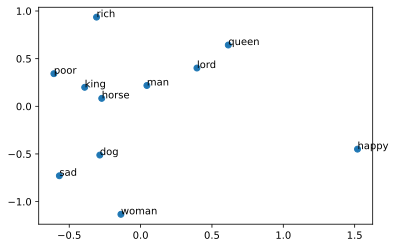

In [275]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

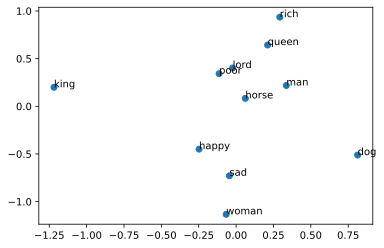

In [276]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()